<a href="https://colab.research.google.com/github/kumar-abhishek/imbalanced-machine-learning-book/blob/ch5-update-main-plots-f2-score/chapter-5/chapter_5_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Plotting helper function

In [1]:
from sklearn.metrics import f1_score, precision_score, recall_score, PrecisionRecallDisplay, precision_recall_curve
from sklearn.metrics import average_precision_score, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from imblearn.metrics import classification_report_imbalanced
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.inspection import DecisionBoundaryDisplay
from matplotlib.colors import ListedColormap
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.datasets import make_classification
from imblearn.datasets import fetch_datasets
from scipy.spatial import distance_matrix
from collections import Counter
from sklearn.base import clone
import matplotlib.pyplot as plt
from sklearn.metrics import make_scorer, fbeta_score
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.metrics import fbeta_score

In [2]:
def plot_dataset(X, y):
  cmap_bold = ["darkorange", "darkblue"]
  markers = {1: "X", 0: "v"}
  sns.scatterplot(
      x=X[:, 0],
      y=X[:, 1],
      hue=y,
      palette=cmap_bold,
      alpha=1.0,
      edgecolor="black",
      style=y, markers=markers
  )

def plot_decision_boundary(X, y, clf, clf_name):
  _, ax = plt.subplots()
  cmap_light = ListedColormap(["orange", "white"])
  disp = DecisionBoundaryDisplay.from_estimator(
      clf,
      X,
      cmap=cmap_light,
      ax=ax,
      response_method="predict",
      alpha=0.5,
      xlabel='feature_1',
      ylabel='feature_2',
  )
  disp.plot(plot_method="contour", cmap="gist_gray", ax = ax, alpha = 1.)
  # Plot also the training points
  plot_dataset(X, y)
  plt.title("Classification using %s classifier" %clf_name)


# from: https://imbalanced-learn.org/stable/auto_examples/combine/plot_comparison_combine.html#sphx-glr-auto-examples-combine-plot-comparison-combine-py
def plot_decision_function(X, y, clf, ax):
  """Plot the decision function of the classifier and the original data"""
  plot_step = 0.02
  x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
  y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
  xx, yy = np.meshgrid(
      np.arange(x_min, x_max, plot_step), np.arange(y_min, y_max, plot_step)
  )

  Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
  Z = Z.reshape(xx.shape)
  ax.contourf(xx, yy, Z, alpha=0.4)
  ax.scatter(X[:, 0], X[:, 1], alpha=0.8, c=y, edgecolor="k")
  ax.set_title(f"Resampling using {clf[0].__class__.__name__}")

In [3]:
def remove_overlapping(X):
    c1_indexes =  np.where(y == 0)[0]
    c2_indexes =  np.where(y == 1)[0]
    centroid = np.mean(X[c1_indexes],axis=0,keepdims= True)
    c2_points =  X[c2_indexes]
    distances = distance_matrix(c2_points , centroid)
    nearest_points_to_c1 = c2_indexes[np.where(distances < 3)[0]]

    move =  np.repeat(np.array([[0,-6]]),nearest_points_to_c1.shape[0], axis=0)
    X[nearest_points_to_c1] = X[nearest_points_to_c1] + move
    return X

# Create dataset

y_train:  Counter({0: 39404, 1: 596})
y_test:  Counter({0: 9851, 1: 149})


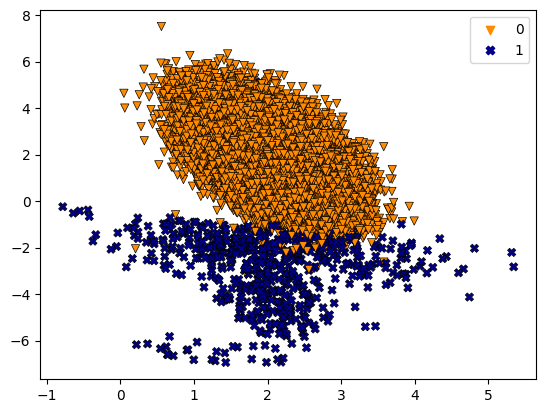

In [4]:
X, y = make_classification(n_samples=50000,
                      n_features=2,
                      n_redundant=0,
                      n_clusters_per_class=1,
                      weights=[0.99],
                      class_sep=2,# how separate the classes are
                      random_state=1)

X = remove_overlapping(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0, stratify=y)

print('y_train: ', Counter(y_train))
print('y_test: ', Counter(y_test))

plot_dataset(X_train, y_train)

# Metacost

In [5]:
class MetaCost:
    """
    +-----------------+--------------+--------------+
    |                 |         Actual class        |
    + Predicted Class +--------------+--------------+
    |                 | class0       | class1       |
    +-----------------+--------------+--------------+
    | h(x) = class0   |      0       |      a       |
    | h(x) = class1   |      c       |      0       |
    +-----------------+--------------+--------------+
    | C = np.array([[0, a],[c, 0]])                 |
    +-----------------------------------------------+

    """
    # def __init__(self, classifier, cost_matrix, resamples=10, fraction=1, num_class=2):
    def __init__(self, classifier, cost_matrix, resamples=50, fraction=1, num_class=2):
        self.classifier = classifier
        self.cost_matrix = cost_matrix
        self.resamples = resamples
        self.fraction = fraction
        self.num_classes = num_class

    def fit(self, X, y):
        # Combine the features and the target into one DataFrame
        data = pd.DataFrame(data=X)
        data['target'] = y

        # Calculate the number of samples in each resample
        num_samples = len(data) * self.fraction

        # Resample the data, train a model on each resample, and store the models
        models = [self._train_on_resample(data.sample(n=int(num_samples), replace=True)) for _ in range(self.resamples)]

        # Relabel the instances based on the models' predictions and the cost matrix
        new_labels = self._relabel_instances(data, models)

        # Train a new model on the data with relabeled instances
        final_model = clone(self.classifier)
        final_model.fit(data.drop(columns=['target']).values, new_labels)

        self.model = final_model
        self.__class__ = self.model.__class__
        self.__dict__ = self.model.__dict__
        return final_model

    def _train_on_resample(self, resample):
        X_resampled = resample.drop(columns=['target']).values
        y_resampled = resample['target'].values
        model = clone(self.classifier)
        return model.fit(X_resampled, y_resampled)

    def _relabel_instances(self, data, models):
        X_array = data.drop(columns=['target']).values
        labels = []
        for i in range(len(data)):
            class_probs = [self._get_class_probs(model, X_array[[i]]) for model in models]
            average_probs = np.mean(class_probs, 0).T
            labels.append(self._get_new_label(average_probs))
        return labels

    def _get_class_probs(self, model, instance):
        return model.predict_proba(instance)

    def _get_new_label(self, average_probs):
        # Multiply the cost matrix with the average probabilities.
        # This gives us the expected costs for each class.
        costs = self.cost_matrix.dot(average_probs)

        # Find the class with the minimum expected cost.
        # This is the new label for the instance.
        return np.argmin(costs)

In [6]:
def compute_scores(model, X_test, y_test):
    y_pred = model.predict(X_test)
    f2 = fbeta_score(y_test, y_pred, beta=2.)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    return f2, precision, recall

# LogisticRegression with and without class weight implementation + MetaCost here
## plot decision function and PR curves comparison


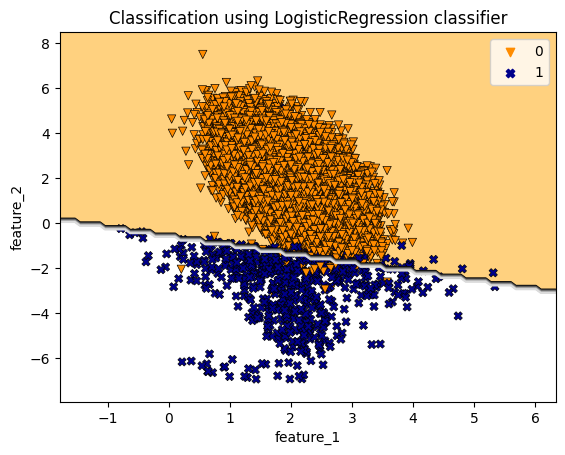

                   pre       rec       spe        f1       geo       iba       sup

    class 0       1.00      1.00      0.92      1.00      0.96      0.93      9851
    class 1       0.93      0.92      1.00      0.92      0.96      0.91       149

avg / total       1.00      1.00      0.92      1.00      0.96      0.93     10000

f2-score: 0.921 precision: 0.926 recall: 0.919


Text(0.5, 0, 'Recall')

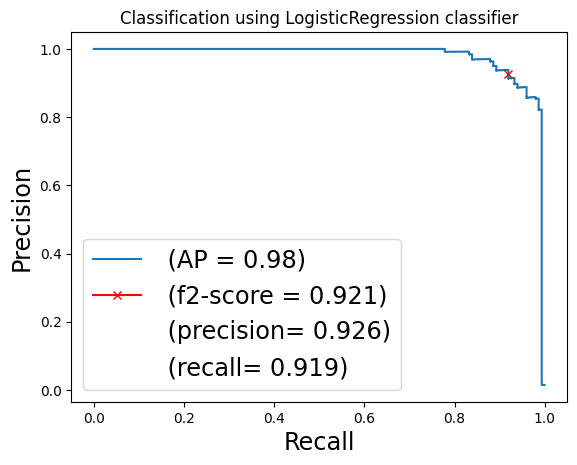

In [7]:
lr = LogisticRegression(random_state=0, max_iter=50).fit(X_train, y_train)

plot_decision_boundary(X_train, y_train, lr, 'LogisticRegression')
plt.show()

print(classification_report_imbalanced(y_test, lr.predict(X_test), target_names=['class 0', 'class 1']))

f2, precision_val, recall_val =  compute_scores(lr, X_test, y_test)

print(f"f2-score: {f2:.3f}", f"precision: {precision_val:.3f}", f"recall: {recall_val:.3f}")

display = PrecisionRecallDisplay.from_estimator(lr, X_test, y_test, ax = plt.gca(), name = "", pos_label=1)
display.ax_.set_title("Classification using LogisticRegression classifier")

# show the f2-score on PR curve so that we know the precision and recall values
y_pred = lr.predict(X_test)
precision, recall, _ = precision_recall_curve(y_test, y_pred)
f2_scores = 5 * recall * precision / (4*precision + recall) # Fbeta = ((1 + beta^2) * Precision * Recall) / (beta^2 * Precision + Recall) with beta=2
plt.plot(recall[np.argmax(f2_scores)], precision[np.argmax(f2_scores)], marker='x', color= "red", label=' (f2-score = '+ str(round(f2, 3))+')')
plt.plot([], [], ' ', label=' (precision= ' + str(round(precision_val, 3)) + ')')
plt.plot([], [], ' ', label=' (recall= ' + str(round(recall_val, 3)) + ')')
plt.legend(loc= 'lower left', fontsize = 'xx-large')
plt.ylabel("Precision", fontsize = 'xx-large')
plt.xlabel("Recall", fontsize = 'xx-large')

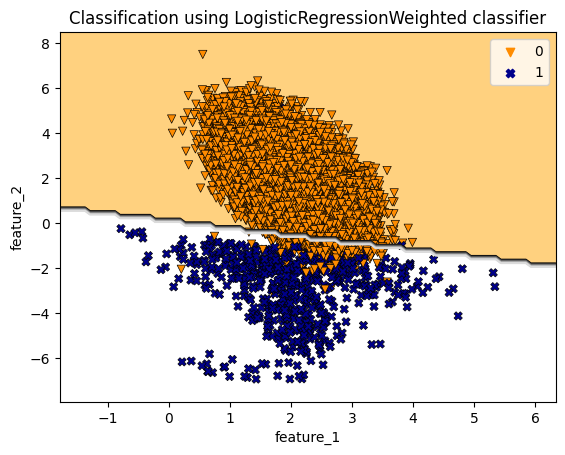

                   pre       rec       spe        f1       geo       iba       sup

    class 0       1.00      0.99      0.99      0.99      0.99      0.98      9851
    class 1       0.59      0.99      0.99      0.74      0.99      0.98       149

avg / total       0.99      0.99      0.99      0.99      0.99      0.98     10000

f2-score: 0.873 precision: 0.587 recall: 0.993


Text(0.5, 0, 'Recall')

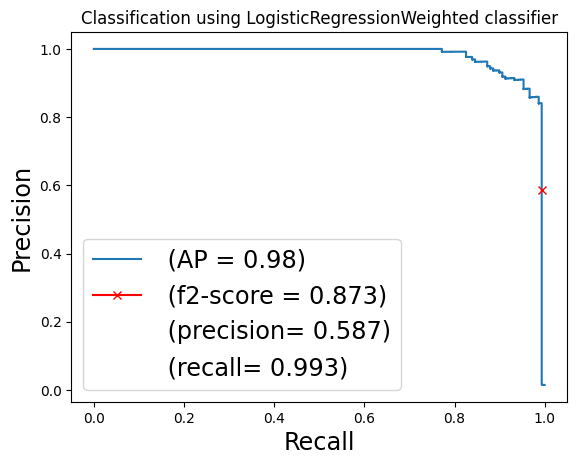

In [8]:
lr_weighted = LogisticRegression(class_weight='balanced', random_state=0, max_iter=50).fit(X_train, y_train)

plot_decision_boundary(X_train, y_train, lr_weighted, 'LogisticRegressionWeighted')
plt.show()

print(classification_report_imbalanced(y_test, lr_weighted.predict(X_test), target_names=['class 0', 'class 1']))

f2, precision_val, recall_val =  compute_scores(lr_weighted, X_test, y_test)


print(f"f2-score: {f2:.3f}", f"precision: {precision_val:.3f}", f"recall: {recall_val:.3f}")

display = PrecisionRecallDisplay.from_estimator(lr_weighted, X_test, y_test, ax = plt.gca(),name = "", pos_label=1)
display.ax_.set_title("Classification using LogisticRegressionWeighted classifier")
y_pred = lr_weighted.predict(X_test)
precision, recall, _ = precision_recall_curve(y_test, y_pred)
f2_scores = 5 * recall * precision / (recall + 4*precision)
plt.plot(recall[np.argmax(f2_scores)], precision[np.argmax(f2_scores)], marker='x', color= "red", label=' (f2-score = '+ str(round(f2, 3))+')')
plt.plot([], [], ' ', label=' (precision= ' + str(round(precision_val, 3)) + ')')
plt.plot([], [], ' ', label=' (recall= ' + str(round(recall_val, 3)) + ')')
plt.legend(loc= 'lower left', fontsize = 'xx-large')
plt.ylabel("Precision", fontsize = 'xx-large')
plt.xlabel("Recall", fontsize = 'xx-large')

The class weighting technique produces pretty much the same average precision but worse f1 score. Let's try to tune the class_weights parameter using grid search that optimizes our f1 score.
We can always try to optimize any other objective like average precision, or precision or recall etc.


In [9]:
def f2_func(y_true, y_pred):
    f2_score = fbeta_score(y_true, y_pred, beta=2)
    return f2_score

def f2_scorer():
    return make_scorer(f2_func)

# Define the parameter grid
param_grid = {'class_weight': [{0: x, 1: 1.0-x} for x in np.linspace(0.05, 0.95, 20)]}

# Instantiate the grid search model
grid_search = GridSearchCV(LogisticRegression(), param_grid, cv=3, scoring=f2_scorer(), n_jobs=-1)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_
best_params

{'class_weight': {0: 0.14473684210526316, 1: 0.8552631578947368}}

# testing LR with class weight = {0: 0.14473684210526316, 1: 0.8552631578947368}}


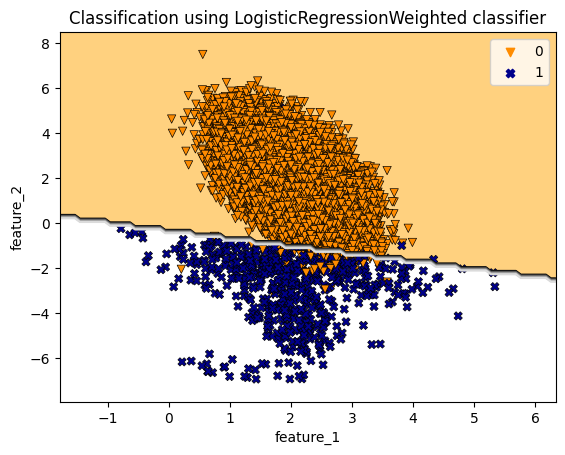

                   pre       rec       spe        f1       geo       iba       sup

    class 0       1.00      1.00      0.99      1.00      1.00      0.99      9851
    class 1       0.83      0.99      1.00      0.91      1.00      0.99       149

avg / total       1.00      1.00      0.99      1.00      1.00      0.99     10000

f2-score: 0.956 precision: 0.831 recall: 0.993


Text(0.5, 0, 'Recall')

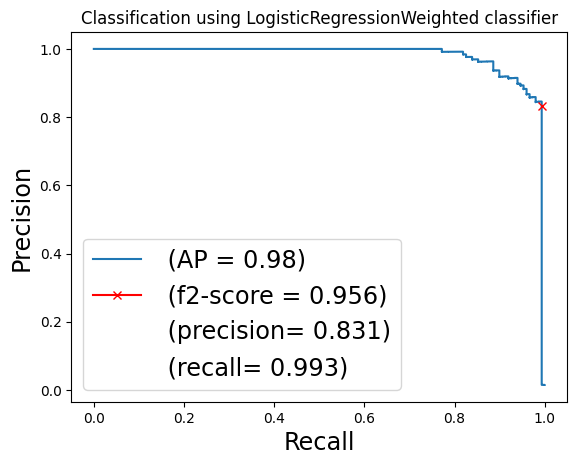

In [10]:
lr_weighted = LogisticRegression(class_weight ={0: best_params['class_weight'][0], 1: best_params['class_weight'][1]}, random_state=0, max_iter=50).fit(X_train, y_train)

plot_decision_boundary(X_train, y_train, lr_weighted, 'LogisticRegressionWeighted')
plt.show()

print(classification_report_imbalanced(y_test, lr_weighted.predict(X_test), target_names=['class 0', 'class 1']))

f2, precision_val, recall_val =  compute_scores(lr_weighted, X_test, y_test)

print(f"f2-score: {f2:.3f}", f"precision: {precision_val:.3f}", f"recall: {recall_val:.3f}")

display = PrecisionRecallDisplay.from_estimator(lr_weighted, X_test, y_test, ax = plt.gca(), name = "", pos_label=1)
display.ax_.set_title("Classification using LogisticRegressionWeighted classifier")
y_pred = lr_weighted.predict(X_test)
precision, recall, _ = precision_recall_curve(y_test, y_pred)
f2_scores = 5 * recall * precision / (recall + 4*precision)
plt.plot(recall[np.argmax(f2_scores)], precision[np.argmax(f2_scores)], marker='x', color= "red", label=' (f2-score = '+ str(round(f2, 3))+')')
plt.plot([], [], ' ', label=' (precision= ' + str(round(precision_val, 3)) + ')')
plt.plot([], [], ' ', label=' (recall= ' + str(round(recall_val, 3)) + ')')
plt.legend(loc= 'lower left', fontsize = 'xx-large')
plt.ylabel("Precision", fontsize = 'xx-large')
plt.xlabel("Recall", fontsize = 'xx-large')

In [11]:
print("train set distribution:")
print(Counter(y_train))
X_test_resampled = np.concatenate((X_test[np.where(y_test==0)[0][:320]], X_test[np.where(y_test==1)[0]]))
y_test_resampled = np.concatenate((y_test[np.where(y_test==0)[0][:320]], y_test[np.where(y_test==1)[0]]))
print("test set distribution:")
print(Counter(y_test_resampled))

y_pred_resampled = lr_weighted.predict(X_test_resampled)
compute_scores(lr_weighted, X_test_resampled, y_test_resampled)[0]

print("\nConfusion Matrix for LR(class_weight = balanced) trained on imbalanced dataset and tested on relatively balanced dataset")
print(confusion_matrix(y_test_resampled, y_pred_resampled))
print("f2-score: %.4f"%(compute_scores(lr_weighted, X_test_resampled, y_test_resampled)[0]))
y_pred_resampled = lr_weighted.predict(X_test_resampled)
y_pred_resampled_prob = lr_weighted.predict_proba(X_test_resampled)[:,1]
print("AP score: %.4f"%(average_precision_score(y_test_resampled, y_pred_resampled_prob) ))

y_pred_resampled = lr.predict(X_test_resampled)
y_pred_resampled_prob = lr.predict_proba(X_test_resampled)[:,1]
print("\nConfusion Matrix for LR(class_weight = None) trained on imbalanced dataset and tested on relatively balanced dataset")
print(confusion_matrix(y_test_resampled, y_pred_resampled))
print("f2-score: %.4f"%(compute_scores(lr, X_test_resampled, y_test_resampled)[0]))
print("AP score: %.4f"%(average_precision_score(y_test_resampled, y_pred_resampled_prob) ))

train set distribution:
Counter({0: 39404, 1: 596})
test set distribution:
Counter({0: 320, 1: 149})

Confusion Matrix for LR(class_weight = balanced) trained on imbalanced dataset and tested on relatively balanced dataset
[[320   0]
 [  1 148]]
f2-score: 0.9946
AP score: 0.9954

Confusion Matrix for LR(class_weight = None) trained on imbalanced dataset and tested on relatively balanced dataset
[[320   0]
 [ 12 137]]
f2-score: 0.9345
AP score: 0.9954


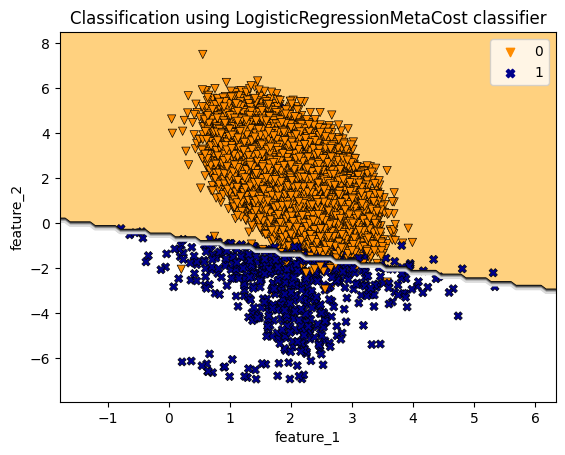

                   pre       rec       spe        f1       geo       iba       sup

    class 0       1.00      1.00      0.91      1.00      0.95      0.92      9851
    class 1       0.94      0.91      1.00      0.93      0.95      0.90       149

avg / total       1.00      1.00      0.91      1.00      0.95      0.92     10000

f2-score: 0.918 precision: 0.938 recall_val: 0.913


Text(0.5, 0, 'Recall')

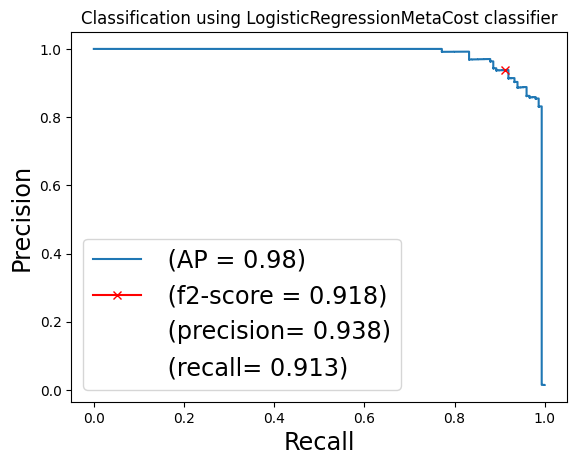

In [12]:
C = np.array([[0, 1], [1, 0]])

logisticRegressionMetaCost = MetaCost(LogisticRegression(random_state=0, max_iter=50, n_jobs=-1), C,
                                          num_class=2).fit(X_train, y_train)

plot_decision_boundary(X_train, y_train, logisticRegressionMetaCost, 'LogisticRegressionMetaCost')
plt.show()

print(classification_report_imbalanced(y_test, logisticRegressionMetaCost.predict(X_test), target_names=['class 0', 'class 1']))

f2, precision_val, recall_val =  compute_scores(logisticRegressionMetaCost, X_test, y_test)

print(f"f2-score: {f2:.3f}", f"precision: {precision_val:.3f}", f"recall_val: {recall_val:.3f}")

display = PrecisionRecallDisplay.from_estimator(logisticRegressionMetaCost, X_test, y_test, ax = plt.gca(),name = "", pos_label=1)
display.ax_.set_title("Classification using LogisticRegressionMetaCost classifier")
y_pred = logisticRegressionMetaCost.predict(X_test)
precision, recall, _ = precision_recall_curve(y_test, y_pred)
f2_scores = 5 * recall * precision / (recall + 4*precision)
plt.plot(recall[np.argmax(f2_scores)], precision[np.argmax(f2_scores)], marker='x', color= "red", label=' (f2-score = '+ str(round(f2, 3))+')')
plt.plot([], [], ' ', label=' (precision= ' + str(round(precision_val, 3)) + ')')
plt.plot([], [], ' ', label=' (recall= ' + str(round(recall_val, 3)) + ')')
plt.legend(loc= 'lower left', fontsize = 'xx-large')
plt.ylabel("Precision", fontsize = 'xx-large')
plt.xlabel("Recall", fontsize = 'xx-large')

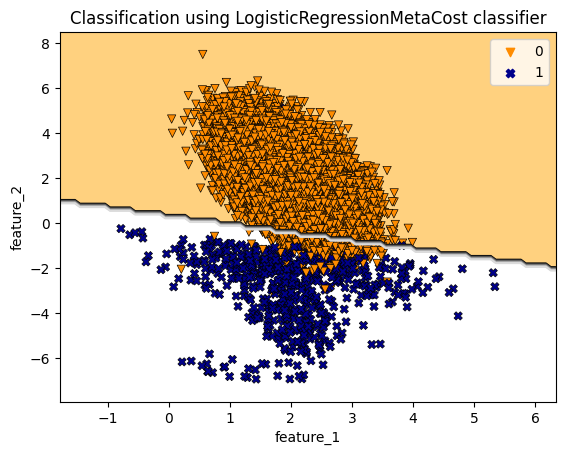

                   pre       rec       spe        f1       geo       iba       sup

    class 0       1.00      0.99      0.99      0.99      0.99      0.98      9851
    class 1       0.52      0.99      0.99      0.69      0.99      0.98       149

avg / total       0.99      0.99      0.99      0.99      0.99      0.98     10000

f2-score: 0.843 precision: 0.525 recall: 0.993


Text(0.5, 0, 'Recall')

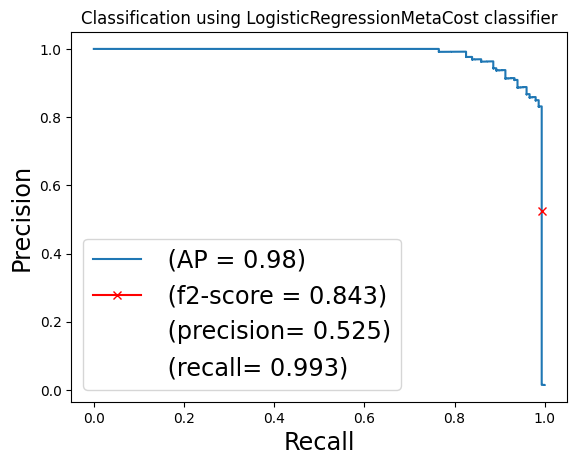

In [13]:
C = np.array([[0, 66], [1, 0]])

logisticRegressionMetaCost = MetaCost(LogisticRegression(random_state=0, max_iter=50, n_jobs=-1), C,
                                          num_class=2).fit(X_train, y_train)

plot_decision_boundary(X_train, y_train, logisticRegressionMetaCost, 'LogisticRegressionMetaCost')
plt.show()

print(classification_report_imbalanced(y_test, logisticRegressionMetaCost.predict(X_test), target_names=['class 0', 'class 1']))

f2, precision_val, recall_val =  compute_scores(logisticRegressionMetaCost, X_test, y_test)

print(f"f2-score: {f2:.3f}", f"precision: {precision_val:.3f}", f"recall: {recall_val:.3f}")

display = PrecisionRecallDisplay.from_estimator(logisticRegressionMetaCost, X_test, y_test, ax = plt.gca(),name = "", pos_label=1)
display.ax_.set_title("Classification using LogisticRegressionMetaCost classifier")
y_pred = logisticRegressionMetaCost.predict(X_test)
precision, recall, _ = precision_recall_curve(y_test, y_pred)
f2_scores = 5 * recall * precision / (recall + 4*precision)
plt.plot(recall[np.argmax(f2_scores)], precision[np.argmax(f2_scores)], marker='x', color= "red", label=' (f2-score = '+ str(round(f2, 3))+')')
plt.plot([], [], ' ', label=' (precision= ' + str(round(precision_val, 3)) + ')')
plt.plot([], [], ' ', label=' (recall= ' + str(round(recall_val, 3)) + ')')
plt.legend(loc= 'lower left', fontsize = 'xx-large')
plt.ylabel("Precision", fontsize = 'xx-large')
plt.xlabel("Recall", fontsize = 'xx-large')

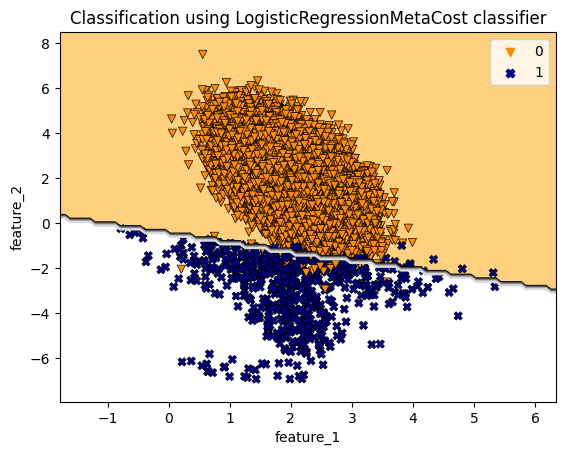

                   pre       rec       spe        f1       geo       iba       sup

    class 0       1.00      1.00      0.93      1.00      0.97      0.94      9851
    class 1       0.91      0.93      1.00      0.92      0.97      0.93       149

avg / total       1.00      1.00      0.93      1.00      0.97      0.94     10000

f2-score: 0.928 precision: 0.908 recall_val: 0.933


Text(0.5, 0, 'Recall')

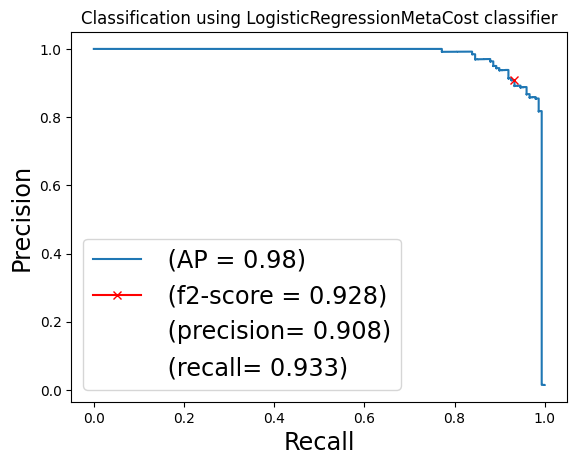

In [14]:
C = np.array([[0, 66], [50, 0]])

logisticRegressionMetaCost = MetaCost(LogisticRegression(random_state=0, max_iter=50, n_jobs=-1), C,
                                          num_class=2).fit(X_train, y_train)

plot_decision_boundary(X_train, y_train, logisticRegressionMetaCost, 'LogisticRegressionMetaCost')
plt.show()

print(classification_report_imbalanced(y_test, logisticRegressionMetaCost.predict(X_test), target_names=['class 0', 'class 1']))

f2, precision_val, recall_val =  compute_scores(logisticRegressionMetaCost, X_test, y_test)

print(f"f2-score: {f2:.3f}", f"precision: {precision_val:.3f}", f"recall_val: {recall_val:.3f}")

display = PrecisionRecallDisplay.from_estimator(logisticRegressionMetaCost, X_test, y_test, ax = plt.gca(),name = "", pos_label=1)
display.ax_.set_title("Classification using LogisticRegressionMetaCost classifier")
y_pred = logisticRegressionMetaCost.predict(X_test)
precision, recall, _ = precision_recall_curve(y_test, y_pred)
f2_scores = 5 * recall * precision / (recall + 4*precision)
plt.plot(recall[np.argmax(f2_scores)], precision[np.argmax(f2_scores)], marker='x', color= "red", label=' (f2-score = '+ str(round(f2, 3))+')')
plt.plot([], [], ' ', label=' (precision= ' + str(round(precision_val, 3)) + ')')
plt.plot([], [], ' ', label=' (recall= ' + str(round(recall_val, 3)) + ')')
plt.legend(loc= 'lower left', fontsize = 'xx-large')
plt.ylabel("Precision", fontsize = 'xx-large')
plt.xlabel("Recall", fontsize = 'xx-large')

# Random Forest with and without class weight + MetaCost implementation here
## plot decision functions and PR curves comparison

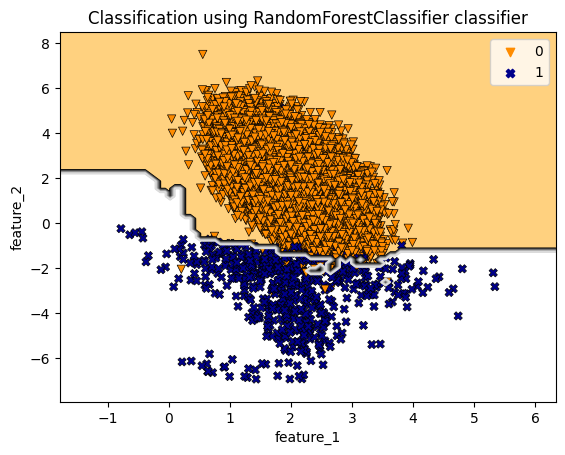

                   pre       rec       spe        f1       geo       iba       sup

    class 0       1.00      1.00      0.94      1.00      0.97      0.94      9851
    class 1       0.93      0.94      1.00      0.94      0.97      0.93       149

avg / total       1.00      1.00      0.94      1.00      0.97      0.94     10000

f2-score: 0.938 precision: 0.933 recall: 0.940


Text(0.5, 0, 'Recall')

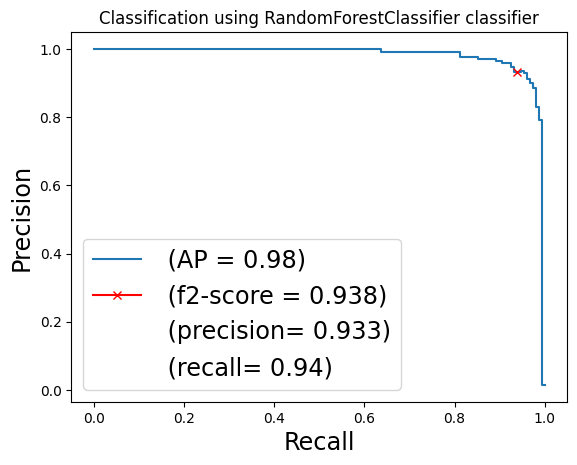

In [15]:
RF_clf = RandomForestClassifier(random_state=0).fit(X_train, y_train)

plot_decision_boundary(X_train, y_train, RF_clf, 'RandomForestClassifier')
plt.show()

print(classification_report_imbalanced(y_test, RF_clf.predict(X_test), target_names=['class 0', 'class 1']))

f2, precision_val, recall_val =  compute_scores(RF_clf, X_test, y_test)

print(f"f2-score: {f2:.3f}", f"precision: {precision_val:.3f}", f"recall: {recall_val:.3f}")

display = PrecisionRecallDisplay.from_estimator(RF_clf, X_test, y_test, ax = plt.gca(),name = "", pos_label=1)
display.ax_.set_title("Classification using RandomForestClassifier classifier")
y_pred = RF_clf.predict(X_test)
precision, recall, _ = precision_recall_curve(y_test, y_pred)
f2_scores = 5 * recall * precision / (recall + 4*precision)
plt.plot(recall[np.argmax(f2_scores)], precision[np.argmax(f2_scores)], marker='x', color= "red", label=' (f2-score = '+ str(round(f2,3))+')')
plt.plot([], [], ' ', label=' (precision= ' + str(round(precision_val, 3)) + ')')
plt.plot([], [], ' ', label=' (recall= ' + str(round(recall_val, 3)) + ')')
plt.legend(loc= 'lower left', fontsize = 'xx-large')
plt.ylabel("Precision", fontsize = 'xx-large')
plt.xlabel("Recall", fontsize = 'xx-large')

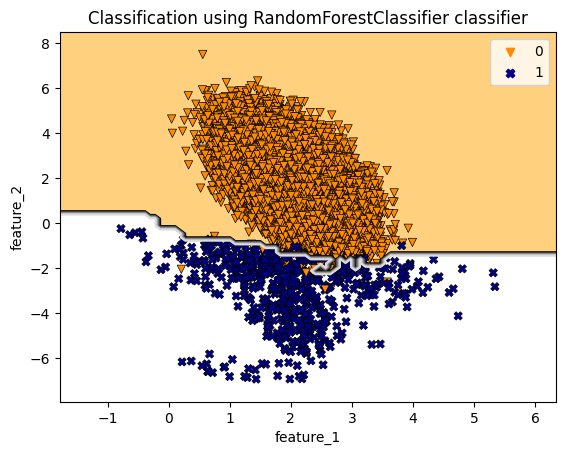

                   pre       rec       spe        f1       geo       iba       sup

    class 0       1.00      1.00      0.94      1.00      0.97      0.94      9851
    class 1       0.95      0.94      1.00      0.94      0.97      0.93       149

avg / total       1.00      1.00      0.94      1.00      0.97      0.94     10000

f2-score: 0.941 precision: 0.946 recall: 0.940


Text(0.5, 0, 'Recall')

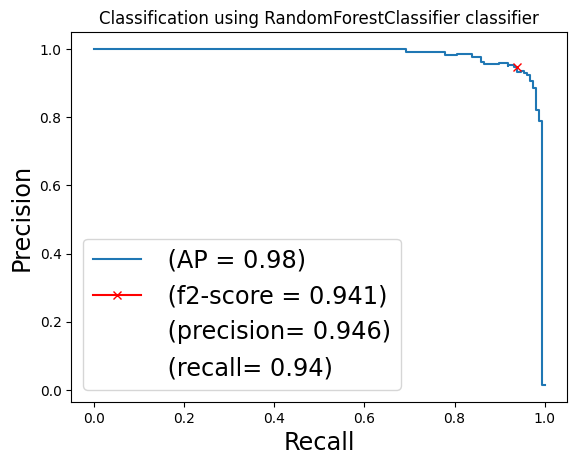

In [16]:
RF_clf = RandomForestClassifier(class_weight="balanced", random_state=0).fit(X_train, y_train)

plot_decision_boundary(X_train, y_train, RF_clf, 'RandomForestClassifier')
plt.show()

print(classification_report_imbalanced(y_test, RF_clf.predict(X_test), target_names=['class 0', 'class 1']))

f2, precision_val, recall_val =  compute_scores(RF_clf, X_test, y_test)

print(f"f2-score: {f2:.3f}", f"precision: {precision_val:.3f}", f"recall: {recall_val:.3f}")

display = PrecisionRecallDisplay.from_estimator(RF_clf, X_test, y_test, ax = plt.gca(),name = "", pos_label=1)
display.ax_.set_title("Classification using RandomForestClassifier classifier")
y_pred = RF_clf.predict(X_test)
precision, recall, _ = precision_recall_curve(y_test, y_pred)
f2_scores = 5 * recall * precision / (recall + 4*precision)
plt.plot(recall[np.argmax(f2_scores)], precision[np.argmax(f2_scores)], marker='x', color= "red", label=' (f2-score = '+ str(round(f2,3))+')')
plt.plot([], [], ' ', label=' (precision= ' + str(round(precision_val, 3)) + ')')
plt.plot([], [], ' ', label=' (recall= ' + str(round(recall_val, 3)) + ')')
plt.legend(loc= 'lower left', fontsize = 'xx-large')
plt.ylabel("Precision", fontsize = 'xx-large')
plt.xlabel("Recall", fontsize = 'xx-large')

# tuned weights


In [17]:
def f2_func(y_true, y_pred):
    f2_score = fbeta_score(y_true, y_pred, beta=2)
    return f2_score

def f2_scorer():
    return make_scorer(f2_func)

# Define the parameter grid
# param_grid = {'scale_pos_weight': [x for x in np.linspace(90, 120, 20)]}
param_grid = {'class_weight': [{0: x, 1: 1.0-x} for x in np.linspace(0.05, 0.95, 20)]}

# Instantiate the grid search model
grid_search = GridSearchCV(RandomForestClassifier(random_state=0), param_grid, cv=3, scoring=f2_scorer(), n_jobs=-1)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_
best_params

{'class_weight': {0: 0.19210526315789472, 1: 0.8078947368421052}}

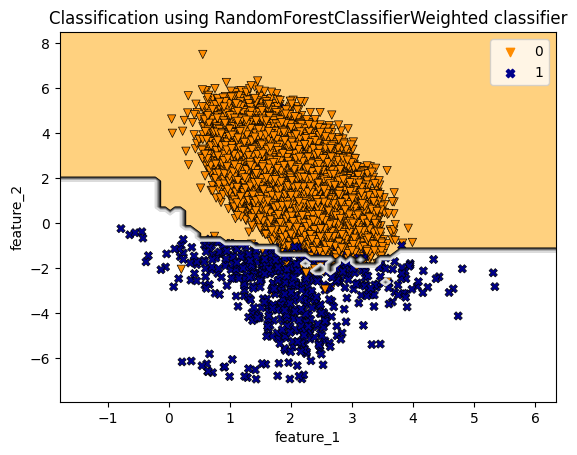

                   pre       rec       spe        f1       geo       iba       sup

    class 0       1.00      1.00      0.94      1.00      0.97      0.94      9851
    class 1       0.94      0.94      1.00      0.94      0.97      0.93       149

avg / total       1.00      1.00      0.94      1.00      0.97      0.94     10000

f2-score: 0.940 precision: 0.940 recall: 0.940


Text(0.5, 0, 'Recall')

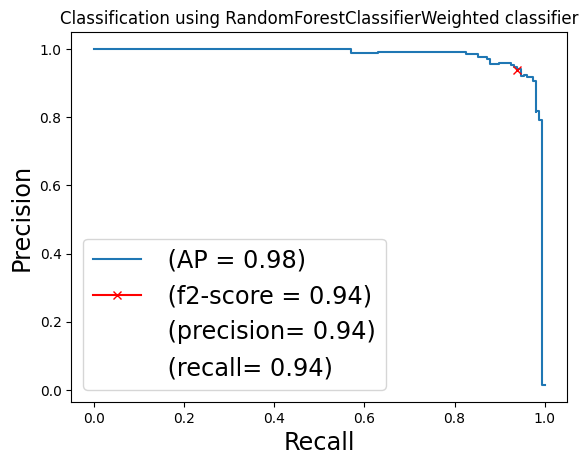

In [18]:
RF_clf = RandomForestClassifier(class_weight={0: best_params['class_weight'][0], 1: best_params['class_weight'][1]}, random_state=0).fit(X_train, y_train)

plot_decision_boundary(X_train, y_train, RF_clf, 'RandomForestClassifierWeighted')
plt.show()

print(classification_report_imbalanced(y_test, RF_clf.predict(X_test), target_names=['class 0', 'class 1']))

f2, precision_val, recall_val =  compute_scores(RF_clf, X_test, y_test)

print(f"f2-score: {f2:.3f}", f"precision: {precision_val:.3f}", f"recall: {recall_val:.3f}")

display = PrecisionRecallDisplay.from_estimator(RF_clf, X_test, y_test, ax = plt.gca(),name = "", pos_label=1)
display.ax_.set_title("Classification using RandomForestClassifierWeighted classifier")
y_pred = RF_clf.predict(X_test)
precision, recall, _ = precision_recall_curve(y_test, y_pred)
f2_scores = 5 * recall * precision / (recall + 4*precision)
plt.plot(recall[np.argmax(f2_scores)], precision[np.argmax(f2_scores)], marker='x', color= "red", label=' (f2-score = '+ str(round(f2,3))+')')
plt.plot([], [], ' ', label=' (precision= ' + str(round(precision_val, 3)) + ')')
plt.plot([], [], ' ', label=' (recall= ' + str(round(recall_val, 3)) + ')')
plt.legend(loc= 'lower left', fontsize = 'xx-large')
plt.ylabel("Precision", fontsize = 'xx-large')
plt.xlabel("Recall", fontsize = 'xx-large')

## metacost random forest

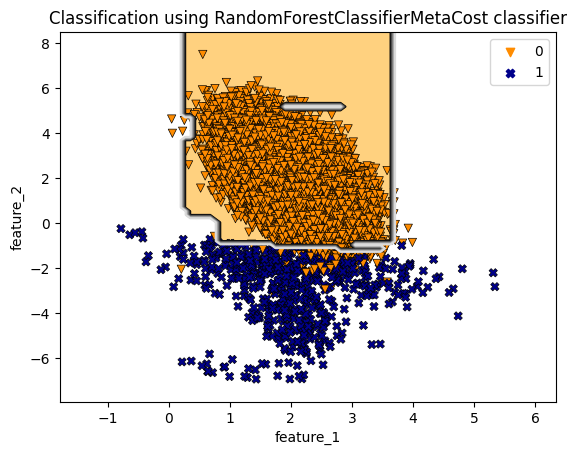

                   pre       rec       spe        f1       geo       iba       sup

    class 0       1.00      0.99      0.99      1.00      0.99      0.99      9851
    class 1       0.70      0.99      0.99      0.82      0.99      0.99       149

avg / total       1.00      0.99      0.99      0.99      0.99      0.99     10000

f2-score: 0.918 precision: 0.705 recall: 0.993
                   pre       rec       spe        f1       geo       iba       sup

    class 0       1.00      1.00      0.94      1.00      0.97      0.94      9851
    class 1       0.94      0.94      1.00      0.94      0.97      0.93       149

avg / total       1.00      1.00      0.94      1.00      0.97      0.94     10000

f2-score: 0.940 precision: 0.940 recall: 0.940


Text(0.5, 0, 'Recall')

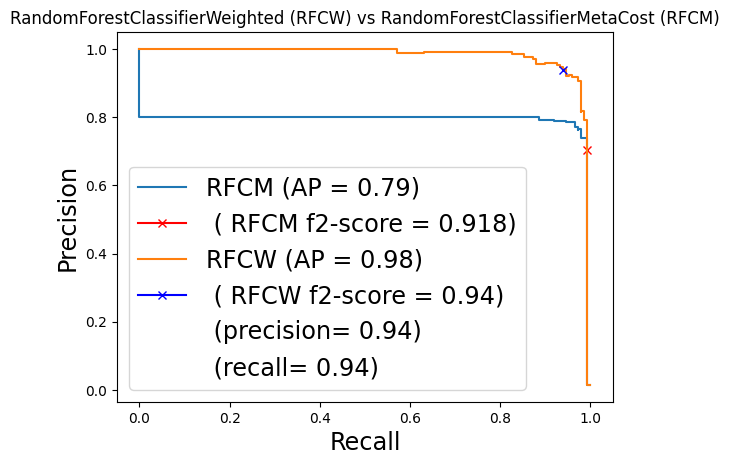

In [19]:
C = np.array([[0, 100], [1, 0]])

RF_clf_MetaCost = MetaCost(RandomForestClassifier(random_state=0), C,
                                          num_class=2).fit(X_train, y_train)

plot_decision_boundary(X_train, y_train, RF_clf_MetaCost, 'RandomForestClassifierMetaCost')
plt.show()

print(classification_report_imbalanced(y_test, RF_clf_MetaCost.predict(X_test), target_names=['class 0', 'class 1']))

f2, precision_val, recall_val =  compute_scores(RF_clf_MetaCost, X_test, y_test)

print(f"f2-score: {f2:.3f}", f"precision: {precision_val:.3f}", f"recall: {recall_val:.3f}")

display = PrecisionRecallDisplay.from_estimator(RF_clf_MetaCost, X_test, y_test, ax = plt.gca(),name = "RFCM", pos_label=1)
display.ax_.set_title("RandomForestClassifierWeighted (RFCW) vs RandomForestClassifierMetaCost (RFCM)")
y_pred = RF_clf_MetaCost.predict(X_test)
precision, recall, _ = precision_recall_curve(y_test, y_pred)
f2_scores = 5 * recall * precision / (recall + 4*precision)
plt.plot(recall[np.argmax(f2_scores)], precision[np.argmax(f2_scores)], marker='x', color= "red", label=' ( RFCM f2-score = '+ str(round(f2,3))+')')


print(classification_report_imbalanced(y_test, RF_clf.predict(X_test), target_names=['class 0', 'class 1']))

f2, precision_val, recall_val =  compute_scores(RF_clf, X_test, y_test)

print(f"f2-score: {f2:.3f}", f"precision: {precision_val:.3f}", f"recall: {recall_val:.3f}")

display = PrecisionRecallDisplay.from_estimator(RF_clf, X_test, y_test, ax = plt.gca(),name = "RFCW", pos_label=1)
y_pred = RF_clf.predict(X_test)
precision, recall, _ = precision_recall_curve(y_test, y_pred)
f2_scores = 5 * recall * precision / (recall + 4*precision)
plt.plot(recall[np.argmax(f2_scores)], precision[np.argmax(f2_scores)], marker='x', color= "blue", label=' ( RFCW f2-score = '+ str(round(f2,3))+')')
plt.plot([], [], ' ', label=' (precision= ' + str(round(precision_val, 3)) + ')')
plt.plot([], [], ' ', label=' (recall= ' + str(round(recall_val, 3)) + ')')
plt.legend(loc= 'lower left', fontsize = 'xx-large')
plt.ylabel("Precision", fontsize = 'xx-large')
plt.xlabel("Recall", fontsize = 'xx-large')

# XGBoost with and without class weight + MetaCost implementation here
## plot decision function and PR curves comparison


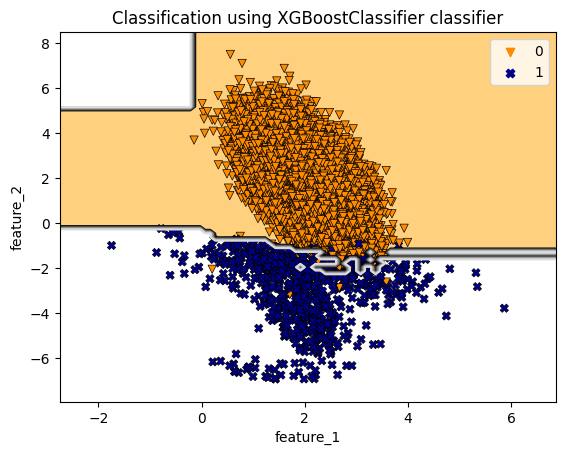

                   pre       rec       spe        f1       geo       iba       sup

    class 0       1.00      1.00      0.93      1.00      0.97      0.94      9851
    class 1       0.95      0.93      1.00      0.94      0.97      0.93       149

avg / total       1.00      1.00      0.93      1.00      0.97      0.94     10000

f2-score: 0.937 precision: 0.952 recall: 0.933


Text(0.5, 0, 'Recall')

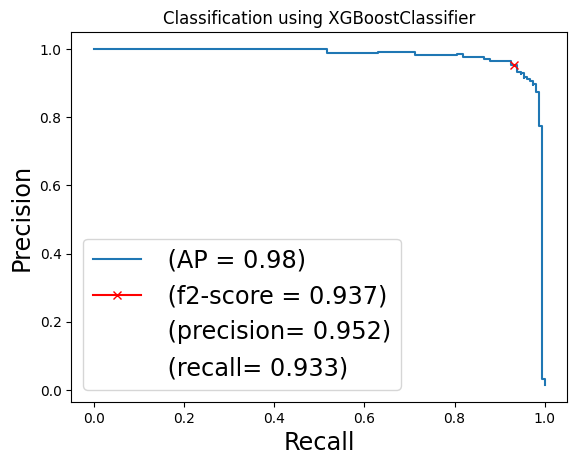

In [20]:
RF_clf = XGBClassifier(random_state=0).fit(X_train, y_train)

plot_decision_boundary(X, y, RF_clf, 'XGBoostClassifier')
plt.show()

print(classification_report_imbalanced(y_test, RF_clf.predict(X_test), target_names=['class 0', 'class 1']))

f2, precision_val, recall_val =  compute_scores(RF_clf, X_test, y_test)

print(f"f2-score: {f2:.3f}", f"precision: {precision_val:.3f}", f"recall: {recall_val:.3f}")

display = PrecisionRecallDisplay.from_estimator(RF_clf, X_test, y_test, ax = plt.gca(),name = "", pos_label=1)
display.ax_.set_title("Classification using XGBoostClassifier")
y_pred = RF_clf.predict(X_test)
precision, recall, _ = precision_recall_curve(y_test, y_pred)
f2_scores = 5 * recall * precision / (recall + 4*precision)
plt.plot(recall[np.argmax(f2_scores)], precision[np.argmax(f2_scores)], marker='x', color= "red", label=' (f2-score = '+ str(round(f2,3))+')')
plt.plot([], [], ' ', label=' (precision= ' + str(round(precision_val, 3)) + ')')
plt.plot([], [], ' ', label=' (recall= ' + str(round(recall_val, 3)) + ')')
plt.legend(loc= 'lower left', fontsize = 'xx-large')
plt.ylabel("Precision", fontsize = 'xx-large')
plt.xlabel("Recall", fontsize = 'xx-large')

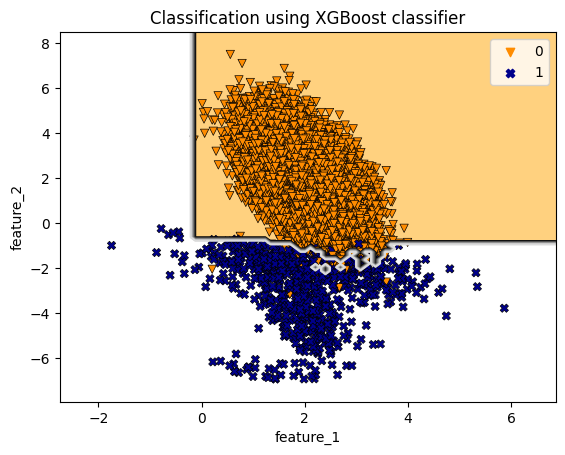

                   pre       rec       spe        f1       geo       iba       sup

    class 0       1.00      1.00      0.97      1.00      0.98      0.97      9851
    class 1       0.87      0.97      1.00      0.91      0.98      0.96       149

avg / total       1.00      1.00      0.97      1.00      0.98      0.97     10000

f2-score: 0.945 precision: 0.867 recall: 0.966


Text(0.5, 0, 'Recall')

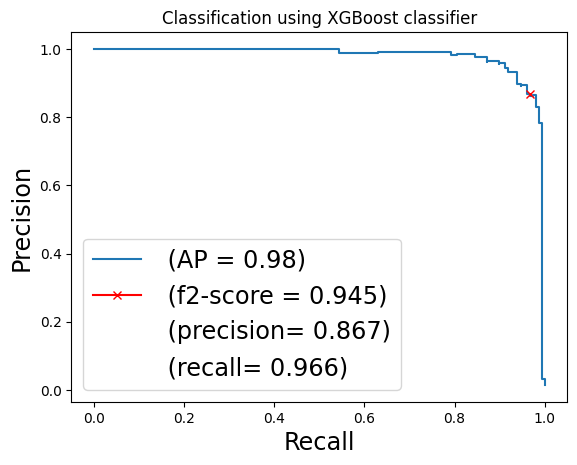

In [21]:
RF_clf = XGBClassifier(scale_pos_weight=99, random_state=0).fit(X_train, y_train)

plot_decision_boundary(X, y, RF_clf, 'XGBoost')
plt.show()

print(classification_report_imbalanced(y_test, RF_clf.predict(X_test), target_names=['class 0', 'class 1']))

f2, precision_val, recall_val =  compute_scores(RF_clf, X_test, y_test)

print(f"f2-score: {f2:.3f}", f"precision: {precision_val:.3f}", f"recall: {recall_val:.3f}")

display = PrecisionRecallDisplay.from_estimator(RF_clf, X_test, y_test, ax = plt.gca(),name = "", pos_label=1)
display.ax_.set_title("Classification using XGBoost classifier")
y_pred = RF_clf.predict(X_test)
precision, recall, _ = precision_recall_curve(y_test, y_pred)
f2_scores = 2 * recall * precision / (recall + precision)
plt.plot(recall[np.argmax(f2_scores)], precision[np.argmax(f2_scores)], marker='x', color= "red", label=' (f2-score = '+ str(round(f2,3))+')')
plt.plot([], [], ' ', label=' (precision= ' + str(round(precision_val, 3)) + ')')
plt.plot([], [], ' ', label=' (recall= ' + str(round(recall_val, 3)) + ')')
plt.legend(loc= 'lower left', fontsize = 'xx-large')
plt.ylabel("Precision", fontsize = 'xx-large')
plt.xlabel("Recall", fontsize = 'xx-large')

# with tuned class_Weights

In [22]:
def f2_func(y_true, y_pred):
    f2_score = fbeta_score(y_true, y_pred, beta=2)
    return f2_score

def f2_scorer():
    return make_scorer(f2_func)

# Define the parameter grid
param_grid = {'scale_pos_weight': [x for x in np.linspace(90, 120, 20)]}

# Instantiate the grid search model
# baseline best: f1: 0.7049180327868854, aur-pr=0.63
grid_search = GridSearchCV(XGBClassifier(random_state=0), param_grid, cv=3, scoring=f2_scorer(), n_jobs=-1)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_
best_params

{'scale_pos_weight': 91.57894736842105}

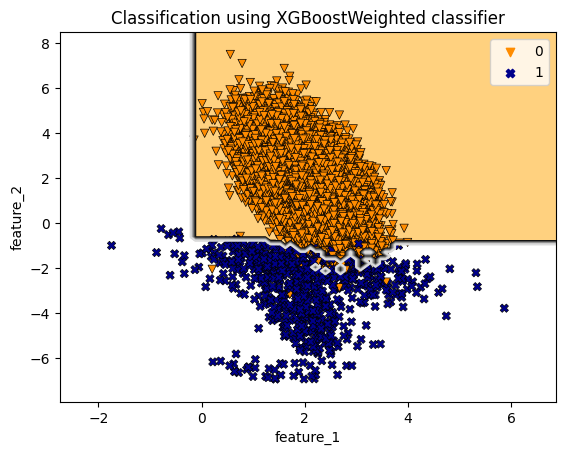

                   pre       rec       spe        f1       geo       iba       sup

    class 0       1.00      1.00      0.97      1.00      0.98      0.97      9851
    class 1       0.87      0.97      1.00      0.92      0.98      0.96       149

avg / total       1.00      1.00      0.97      1.00      0.98      0.97     10000

f2-score: 0.946 precision: 0.873 recall: 0.966


Text(0.5, 0, 'Recall')

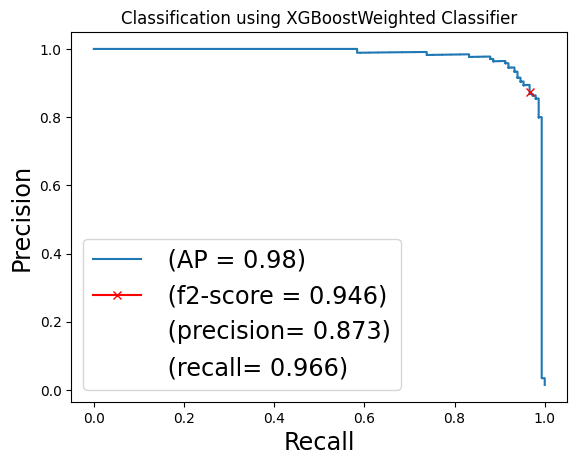

In [23]:
RF_clf = XGBClassifier(scale_pos_weight=91.57894736842105, random_state=0).fit(X_train, y_train)

plot_decision_boundary(X, y, RF_clf, 'XGBoostWeighted')
plt.show()

print(classification_report_imbalanced(y_test, RF_clf.predict(X_test), target_names=['class 0', 'class 1']))

f2, precision_val, recall_val =  compute_scores(RF_clf, X_test, y_test)

print(f"f2-score: {f2:.3f}", f"precision: {precision_val:.3f}", f"recall: {recall_val:.3f}")

display = PrecisionRecallDisplay.from_estimator(RF_clf, X_test, y_test, ax = plt.gca(),name = "", pos_label=1)
display.ax_.set_title("Classification using XGBoostWeighted Classifier")
y_pred = RF_clf.predict(X_test)
precision, recall, _ = precision_recall_curve(y_test, y_pred)
f2_scores = 5 * recall * precision / (recall + 4*precision)
plt.plot(recall[np.argmax(f2_scores)], precision[np.argmax(f2_scores)], marker='x', color= "red", label=' (f2-score = '+ str(round(f2,3))+')')
plt.plot([], [], ' ', label=' (precision= ' + str(round(precision_val, 3)) + ')')
plt.plot([], [], ' ', label=' (recall= ' + str(round(recall_val, 3)) + ')')
plt.legend(loc= 'lower left', fontsize = 'xx-large')
plt.ylabel("Precision", fontsize = 'xx-large')
plt.xlabel("Recall", fontsize = 'xx-large')

# Decision Tree

In [24]:
# DT_clf = DecisionTreeClassifier(class_weight={0: 0.28684210526315784, 1: 0.7131578947368422}, random_state=0, max_depth=6).fit(X_train, y_train)

# plot_decision_boundary(X, y, DT_clf, 'DecisionTreeWeighted')
# plt.show()

# print(classification_report_imbalanced(y_test, DT_clf.predict(X_test), target_names=['class 0', 'class 1']))

# f2, precision, recall =  compute_scores(DT_clf, X_test, y_test)

# print(f"f2-score: {f2:.3f}", f"precision: {precision:.3f}", f"recall: {recall:.3f}")

# display = PrecisionRecallDisplay.from_estimator(DT_clf, X_test, y_test, ax = plt.gca(),name = "", pos_label=1)
# display.ax_.set_title("Classification using DecisionTreeWeighted Classifier")
# y_pred = DT_clf.predict(X_test)
# precision, recall, _ = precision_recall_curve(y_test, y_pred)
# f2_scores = 5 * recall * precision / (recall + 4*precision)
# plt.plot(recall[np.argmax(f2_scores)], precision[np.argmax(f2_scores)], marker='x', color= "red", label=' (f2-score = '+ str(round(f2,2))+')')
# plt.legend(loc= 'lower left', fontsize = 'xx-large')
# plt.ylabel("Precision", fontsize = 'xx-large')
# plt.xlabel("Recall", fontsize = 'xx-large')

## metacost decision tree

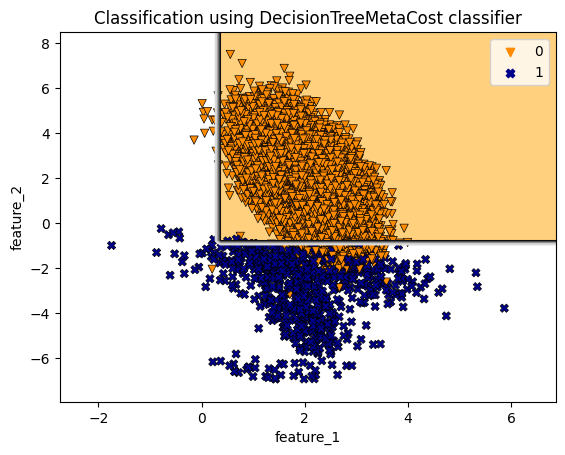

                   pre       rec       spe        f1       geo       iba       sup

    class 0       1.00      0.99      0.99      1.00      0.99      0.98      9851
    class 1       0.68      0.99      0.99      0.81      0.99      0.98       149

avg / total       1.00      0.99      0.99      0.99      0.99      0.98     10000

f2-score: 0.905 precision: 0.681 recall: 0.987


Text(0.5, 0, 'Recall')

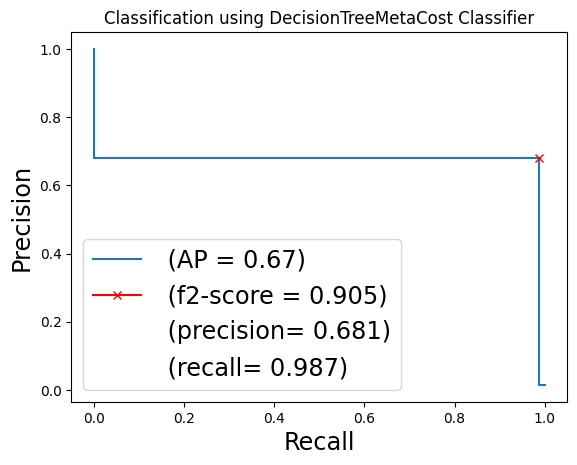

In [25]:
C = np.array([[0, 100], [1, 0]])

DT_clf_MetaCost = MetaCost(DecisionTreeClassifier(random_state=0, max_depth=6), C,
                                          num_class=2).fit(X_train, y_train)

plot_decision_boundary(X, y, DT_clf_MetaCost, 'DecisionTreeMetaCost')
plt.show()

print(classification_report_imbalanced(y_test, DT_clf_MetaCost.predict(X_test), target_names=['class 0', 'class 1']))

f2, precision_val, recall_val =  compute_scores(DT_clf_MetaCost, X_test, y_test)

print(f"f2-score: {f2:.3f}", f"precision: {precision_val:.3f}", f"recall: {recall_val:.3f}")

display = PrecisionRecallDisplay.from_estimator(DT_clf_MetaCost, X_test, y_test, ax = plt.gca(),name = "", pos_label=1)
display.ax_.set_title("Classification using DecisionTreeMetaCost Classifier")
y_pred = DT_clf_MetaCost.predict(X_test)
precision, recall, _ = precision_recall_curve(y_test, y_pred)
f2_scores = 2 * recall * precision / (recall + precision)
plt.plot(recall[np.argmax(f2_scores)], precision[np.argmax(f2_scores)], marker='x', color= "red", label=' (f2-score = '+ str(round(f2,3))+')')
plt.plot([], [], ' ', label=' (precision= ' + str(round(precision_val, 3)) + ')')
plt.plot([], [], ' ', label=' (recall= ' + str(round(recall_val, 3)) + ')')
plt.legend(loc= 'lower left', fontsize = 'xx-large')
plt.ylabel("Precision", fontsize = 'xx-large')
plt.xlabel("Recall", fontsize = 'xx-large')

# metacost XGBoost

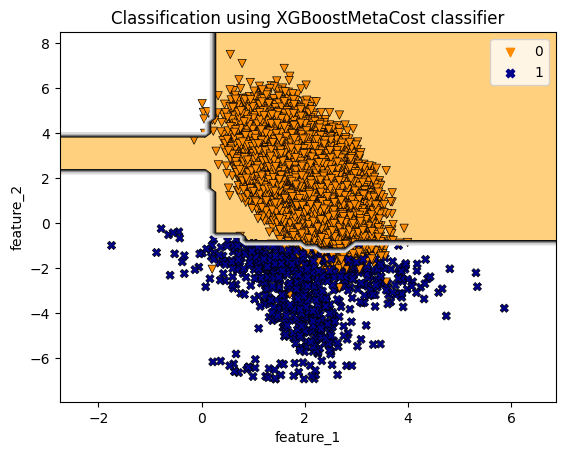

Text(0.5, 0, 'Recall')

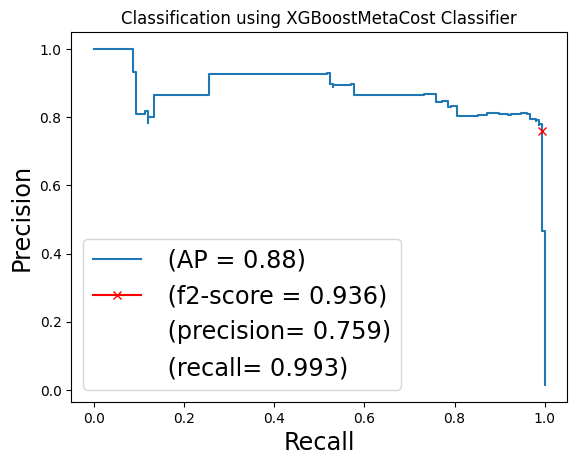

In [26]:
C = np.array([[0, 100], [1, 0]])

XGB_clf_MetaCost = MetaCost(XGBClassifier(random_state=0), C,
                                          num_class=2).fit(X_train, y_train)

plot_decision_boundary(X, y, XGB_clf_MetaCost, 'XGBoostMetaCost')
plt.show()

f2, precision_val, recall_val =  compute_scores(XGB_clf_MetaCost, X_test, y_test)

display = PrecisionRecallDisplay.from_estimator(XGB_clf_MetaCost, X_test, y_test, ax = plt.gca(),name = "", pos_label=1)
display.ax_.set_title("Classification using XGBoostMetaCost Classifier")
y_pred = XGB_clf_MetaCost.predict(X_test)
precision, recall, _ = precision_recall_curve(y_test, y_pred)
f2_scores = 5 * recall * precision / (recall + 4*precision)
plt.plot(recall[np.argmax(f2_scores)], precision[np.argmax(f2_scores)], marker='x', color= "red", label=' (f2-score = '+ str(round(f2,3))+')')
plt.plot([], [], ' ', label=' (precision= ' + str(round(precision_val, 3)) + ')')
plt.plot([], [], ' ', label=' (recall= ' + str(round(recall_val, 3)) + ')')
plt.legend(loc= 'lower left', fontsize = 'xx-large')
plt.ylabel("Precision", fontsize = 'xx-large')
plt.xlabel("Recall", fontsize = 'xx-large')

In [27]:
print(classification_report_imbalanced(y_test, XGB_clf_MetaCost.predict(X_test), target_names=['class 0', 'class 1']))

f2, precision_val, recall_val =  compute_scores(XGB_clf_MetaCost, X_test, y_test)

print(f"f2-score: {f2:.3f}", f"precision: {precision_val:.3f}", f"recall: {recall_val:.3f}")

                   pre       rec       spe        f1       geo       iba       sup

    class 0       1.00      1.00      0.99      1.00      0.99      0.99      9851
    class 1       0.76      0.99      1.00      0.86      0.99      0.99       149

avg / total       1.00      1.00      0.99      1.00      0.99      0.99     10000

f2-score: 0.936 precision: 0.759 recall: 0.993



# DecisionTreeClassifier with and without class weight + MetaCost implementation here
## plot decision function and PR curves comparison


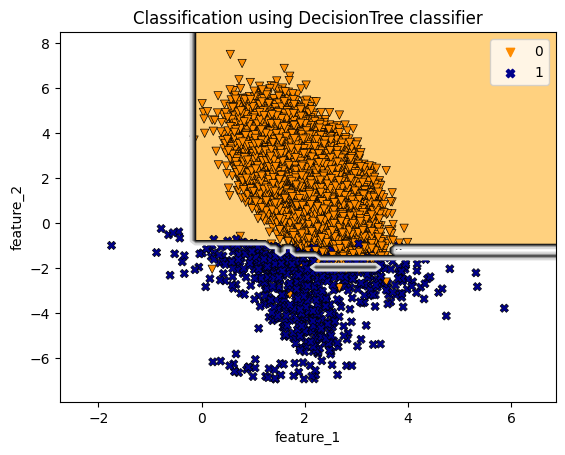

                   pre       rec       spe        f1       geo       iba       sup

    class 0       1.00      1.00      0.94      1.00      0.97      0.94      9851
    class 1       0.90      0.94      1.00      0.92      0.97      0.93       149

avg / total       1.00      1.00      0.94      1.00      0.97      0.94     10000

f2-score: 0.932 precision: 0.903 recall: 0.940


Text(0.5, 0, 'Recall')

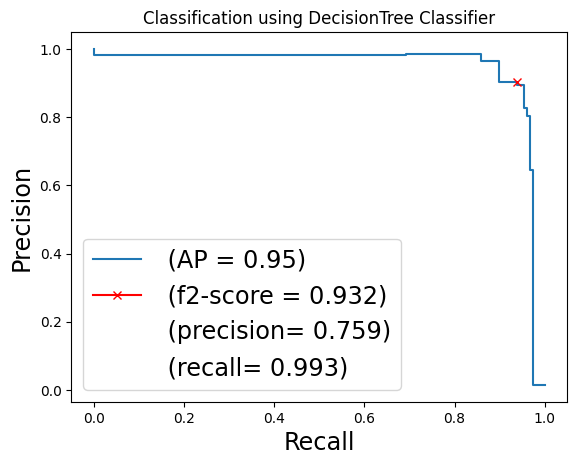

In [28]:
DT_clf = DecisionTreeClassifier(random_state=0, max_depth=6).fit(X_train, y_train)

plot_decision_boundary(X, y, DT_clf, 'DecisionTree')
plt.show()

print(classification_report_imbalanced(y_test, DT_clf.predict(X_test), target_names=['class 0', 'class 1']))

f2, precision, recall =  compute_scores(DT_clf, X_test, y_test)

print(f"f2-score: {f2:.3f}", f"precision: {precision:.3f}", f"recall: {recall:.3f}")

display = PrecisionRecallDisplay.from_estimator(DT_clf, X_test, y_test, ax = plt.gca(),name = "", pos_label=1)
display.ax_.set_title("Classification using DecisionTree Classifier")
y_pred = DT_clf.predict(X_test)
precision, recall, _ = precision_recall_curve(y_test, y_pred)
f2_scores = 5 * recall * precision / (recall + 4*precision)
plt.plot(recall[np.argmax(f2_scores)], precision[np.argmax(f2_scores)], marker='x', color= "red", label=' (f2-score = '+ str(round(f2, 3))+')')
plt.plot([], [], ' ', label=' (precision= ' + str(round(precision_val, 3)) + ')')
plt.plot([], [], ' ', label=' (recall= ' + str(round(recall_val, 3)) + ')')

plt.legend(loc= 'lower left', fontsize = 'xx-large')
plt.ylabel("Precision", fontsize = 'xx-large')
plt.xlabel("Recall", fontsize = 'xx-large')

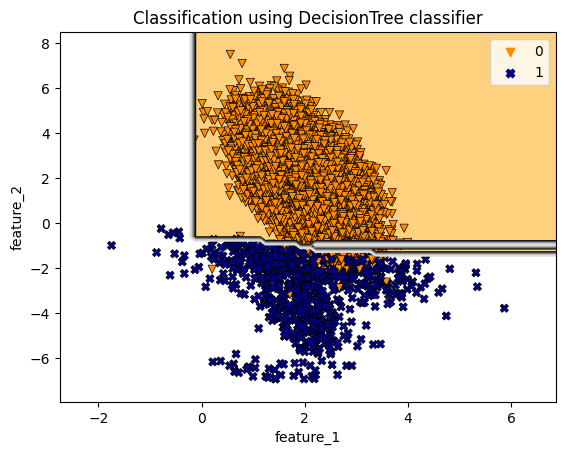

                   pre       rec       spe        f1       geo       iba       sup

    class 0       1.00      1.00      0.99      1.00      0.99      0.98      9851
    class 1       0.77      0.99      1.00      0.86      0.99      0.98       149

avg / total       1.00      1.00      0.99      1.00      0.99      0.98     10000

f2-score: 0.934 precision: 0.770 recall: 0.987


Text(0.5, 0, 'Recall')

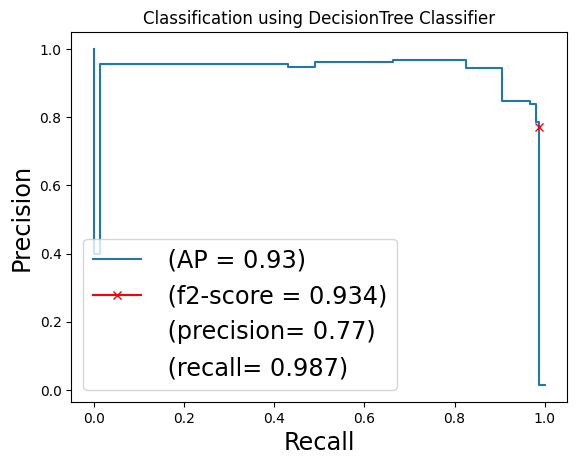

In [29]:
DT_clf = DecisionTreeClassifier(class_weight="balanced", random_state=0, max_depth=6).fit(X_train, y_train)

plot_decision_boundary(X, y, DT_clf, 'DecisionTree')
plt.show()

print(classification_report_imbalanced(y_test, DT_clf.predict(X_test), target_names=['class 0', 'class 1']))

f2, precision_val, recall_val =  compute_scores(DT_clf, X_test, y_test)

print(f"f2-score: {f2:.3f}", f"precision: {precision_val:.3f}", f"recall: {recall_val:.3f}")

display = PrecisionRecallDisplay.from_estimator(DT_clf, X_test, y_test, ax = plt.gca(),name = "", pos_label=1)
display.ax_.set_title("Classification using DecisionTree Classifier")
y_pred = DT_clf.predict(X_test)
precision, recall, _ = precision_recall_curve(y_test, y_pred)
f2_scores = 5 * recall * precision / (recall + 4*precision)
plt.plot(recall[np.argmax(f2_scores)], precision[np.argmax(f2_scores)], marker='x', color= "red", label=' (f2-score = '+ str(round(f2, 3))+')')
plt.plot([], [], ' ', label=' (precision= ' + str(round(precision_val, 3)) + ')')
plt.plot([], [], ' ', label=' (recall= ' + str(round(recall_val, 3)) + ')')
plt.legend(loc= 'lower left', fontsize = 'xx-large')
plt.ylabel("Precision", fontsize = 'xx-large')
plt.xlabel("Recall", fontsize = 'xx-large')

# with tuned class_Weights

In [30]:
from sklearn.metrics import make_scorer, fbeta_score

def f2_func(y_true, y_pred):
    f2_score = fbeta_score(y_true, y_pred, beta=2.0)
    return f2_score

def f2_scorer():
    return make_scorer(f2_func)

# Define the parameter grid
param_grid = {'class_weight': [{0: x, 1: 1.0-x} for x in np.linspace(0.01, 0.99, 60)]}

# Instantiate the grid search model
grid_search = GridSearchCV(DecisionTreeClassifier(random_state=0, max_depth=6), param_grid, cv=3, scoring=f2_scorer(), n_jobs=-1)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_
best_params

{'class_weight': {0: 0.2425423728813559, 1: 0.7574576271186441}}

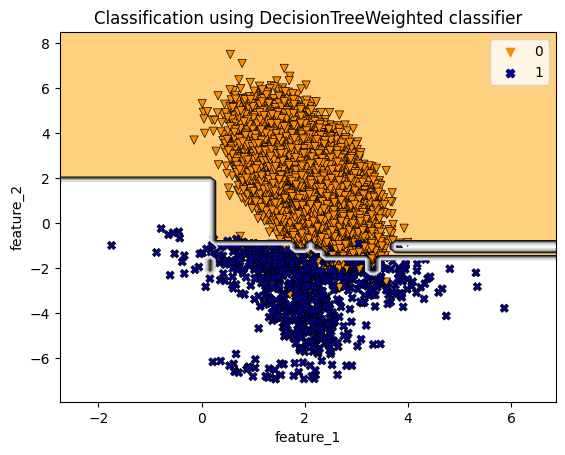

                   pre       rec       spe        f1       geo       iba       sup

    class 0       1.00      1.00      0.94      1.00      0.97      0.94      9851
    class 1       0.90      0.94      1.00      0.92      0.97      0.93       149

avg / total       1.00      1.00      0.94      1.00      0.97      0.94     10000

f2-score: 0.931 precision: 0.897 recall: 0.940


Text(0.5, 0, 'Recall')

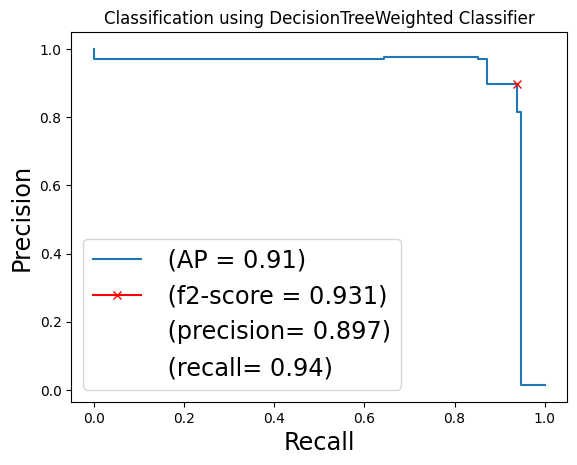

In [31]:
DTW_clf = DecisionTreeClassifier(class_weight={0: best_params['class_weight'][0], 1: best_params['class_weight'][1]}, random_state=0, max_depth=6).fit(X_train, y_train)

plot_decision_boundary(X, y, DTW_clf, 'DecisionTreeWeighted')
plt.show()

print(classification_report_imbalanced(y_test, DTW_clf.predict(X_test), target_names=['class 0', 'class 1']))

f2, precision_val, recall_val =  compute_scores(DTW_clf, X_test, y_test)

print(f"f2-score: {f2:.3f}", f"precision: {precision_val:.3f}", f"recall: {recall_val:.3f}")

display = PrecisionRecallDisplay.from_estimator(DTW_clf, X_test, y_test, ax = plt.gca(),name = "", pos_label=1)
display.ax_.set_title("Classification using DecisionTreeWeighted Classifier")
y_pred = DTW_clf.predict(X_test)
precision, recall, _ = precision_recall_curve(y_test, y_pred)
f2_scores = 5 * recall * precision / (recall + 4*precision)
plt.plot(recall[np.argmax(f2_scores)], precision[np.argmax(f2_scores)], marker='x', color= "red", label=' (f2-score = '+ str(round(f2, 3))+')')
plt.plot([], [], ' ', label=' (precision= ' + str(round(precision_val, 3)) + ')')
plt.plot([], [], ' ', label=' (recall= ' + str(round(recall_val, 3)) + ')')
plt.legend(loc= 'lower left', fontsize = 'xx-large')
plt.ylabel("Precision", fontsize = 'xx-large')
plt.xlabel("Recall", fontsize = 'xx-large')

## metacost decision tree

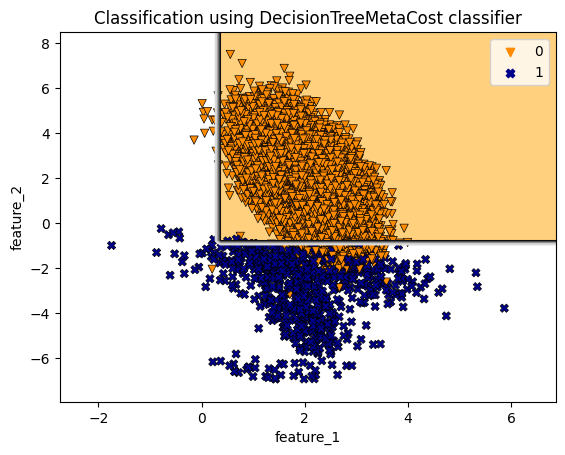

                   pre       rec       spe        f1       geo       iba       sup

    class 0       1.00      0.99      0.99      1.00      0.99      0.98      9851
    class 1       0.69      0.99      0.99      0.81      0.99      0.98       149

avg / total       1.00      0.99      0.99      0.99      0.99      0.98     10000

f2-score: 0.909 precision: 0.690 recall: 0.987


Text(0.5, 0, 'Recall')

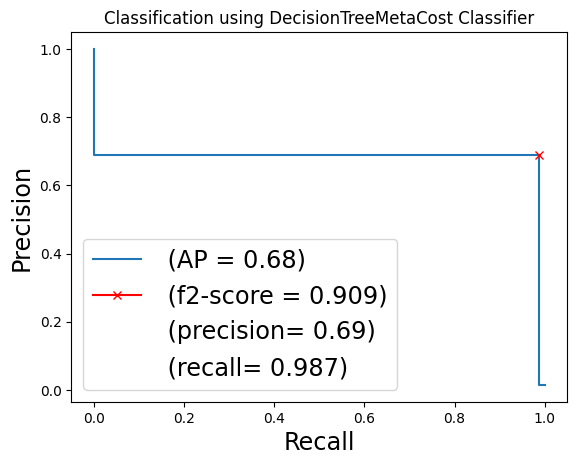

In [32]:
C = np.array([[0, 100], [1, 0]])


DT_clf_MetaCost = MetaCost(DecisionTreeClassifier(random_state=0, max_depth=6), C,
                                          num_class=2).fit(X_train, y_train)

plot_decision_boundary(X, y, DT_clf_MetaCost, 'DecisionTreeMetaCost')
plt.show()

print(classification_report_imbalanced(y_test, DT_clf_MetaCost.predict(X_test), target_names=['class 0', 'class 1']))

f2, precision_val, recall_val =  compute_scores(DT_clf_MetaCost, X_test, y_test)

print(f"f2-score: {f2:.3f}", f"precision: {precision_val:.3f}", f"recall: {recall_val:.3f}")

display = PrecisionRecallDisplay.from_estimator(DT_clf_MetaCost, X_test, y_test, ax = plt.gca(),name = "", pos_label=1)
display.ax_.set_title("Classification using DecisionTreeMetaCost Classifier")
y_pred = DT_clf_MetaCost.predict(X_test)
precision, recall, _ = precision_recall_curve(y_test, y_pred)
f2_scores = 5 * recall * precision / (recall + 4*precision)
plt.plot(recall[np.argmax(f2_scores)], precision[np.argmax(f2_scores)], marker='x', color= "red", label=' (f2-score = '+ str(round(f2,3))+')')
plt.plot([], [], ' ', label=' (precision= ' + str(round(precision_val, 3)) + ')')
plt.plot([], [], ' ', label=' (recall= ' + str(round(recall_val, 3)) + ')')
plt.legend(loc= 'lower left', fontsize = 'xx-large')
plt.ylabel("Precision", fontsize = 'xx-large')
plt.xlabel("Recall", fontsize = 'xx-large')

# Threshold adjustment

Adjust the threshold of previous models (without the "balanced" or "class_weight" versions) and get their F2 scores on test set.

For threshold adjustment, we should create a separate small validation set from the original dataset.


In [33]:
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size = 0.2, random_state = 0, stratify=y_train)
print(Counter(y_val), Counter(y_tr))

Counter({0: 7881, 1: 119}) Counter({0: 31523, 1: 477})


LR Best Threshold on Validation=0.203393, F2-Score=0.948
RF Best Threshold on Validation=0.090000, F2-Score=0.949
XGBoost Best Threshold on Validation=0.320288, F2-Score=0.954
Decision Tree Best Threshold on Validation=0.121951, F2-Score=0.935
Weighted LR Best Threshold on Validation=0.371031, F2-Score=0.946
Weighted RF Best Threshold on Validation=0.070000, F2-Score=0.949
Weighted XGBoost Best Threshold on Validation=0.525438, F2-Score=0.948
Weighted Decision Tree Best Threshold on Validation=0.229244, F2-Score=0.928


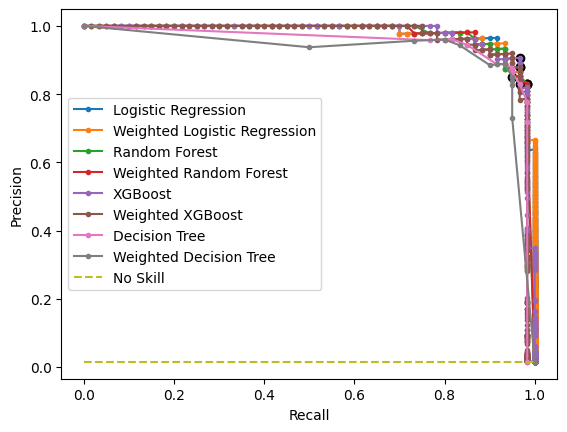

In [34]:
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size = 0.1, random_state = 0, stratify=y_train)

lr = LogisticRegression(random_state=0, max_iter=50)
lr.fit(X_tr, y_tr)
# predict probabilities
yhat = lr.predict_proba(X_val)
yhat = yhat[:, 1]
precision, recall, LR_thresholds = precision_recall_curve(y_val, yhat)
plt.plot(recall, precision, marker='.', label='Logistic Regression')
LR_fscore = (5 * precision * recall) / (4*precision + recall)
LR_ix = np.argmax(LR_fscore)
plt.scatter(recall[LR_ix], precision[LR_ix], marker='o', color='black')

lr_b = LogisticRegression(class_weight="balanced", random_state=0, max_iter=50)
lr_b.fit(X_tr, y_tr)
# predict probabilities
yhat = lr_b.predict_proba(X_val)
yhat = yhat[:, 1]
precision, recall, LR_b_thresholds = precision_recall_curve(y_val, yhat)
LR_b_fscore = (5 * precision * recall) / (4*precision + recall)
LR_b_ix = np.argmax(LR_b_fscore)
plt.scatter(recall[LR_b_ix], precision[LR_b_ix], marker='o', color='black')

lr_w = LogisticRegression(class_weight={0: 0.14473684210526316, 1: 0.8552631578947368}, random_state=0, max_iter=50)
lr_w.fit(X_tr, y_tr)
# predict probabilities
yhat = lr_w.predict_proba(X_val)
yhat = yhat[:, 1]
precision, recall, LR_w_thresholds = precision_recall_curve(y_val, yhat)
plt.plot(recall, precision, marker='.', label='Weighted Logistic Regression')
LR_w_fscore = (5 * precision * recall) / (4*precision + recall)
LR_w_ix = np.argmax(LR_w_fscore)

RF_clf = RandomForestClassifier(random_state=0)
RF_clf.fit(X_tr, y_tr)
# predict probabilities
yhat = RF_clf.predict_proba(X_val)
yhat = yhat[:, 1]
precision, recall, RF_thresholds = precision_recall_curve(y_val, yhat)
plt.plot(recall, precision, marker='.', label='Random Forest')
RF_fscore = (5 * precision * recall) / (4*precision + recall)
RF_ix = np.argmax(RF_fscore)
plt.scatter(recall[RF_ix], precision[RF_ix], marker='o', color='black')

RF_b_clf = RandomForestClassifier(class_weight="balanced", random_state=0)
RF_b_clf.fit(X_tr, y_tr)
# predict probabilities
yhat = RF_b_clf.predict_proba(X_val)
yhat = yhat[:, 1]
precision, recall, RF_b_thresholds = precision_recall_curve(y_val, yhat)
RF_b_fscore = (5 * precision * recall) / (4*precision + recall)
RF_b_ix = np.argmax(RF_b_fscore)

RF_w_clf = RandomForestClassifier(class_weight={0: 0.19210526315789472, 1: 0.8078947368421052}, random_state=0)
RF_w_clf.fit(X_tr, y_tr)
# predict probabilities
yhat = RF_w_clf.predict_proba(X_val)
yhat = yhat[:, 1]
precision, recall, RF_w_thresholds = precision_recall_curve(y_val, yhat)
plt.plot(recall, precision, marker='.', label='Weighted Random Forest')
RF_w_fscore = (5 * precision * recall) / (4*precision + recall)
RF_w_ix = np.argmax(RF_w_fscore)
plt.scatter(recall[RF_w_ix], precision[RF_w_ix], marker='o', color='black')

xgb_clf = XGBClassifier(random_state=0)
xgb_clf.fit(X_tr, y_tr)
# predict probabilities
yhat = xgb_clf.predict_proba(X_val)
yhat = yhat[:, 1]
precision, recall, xgb_thresholds = precision_recall_curve(y_val, yhat)
plt.plot(recall, precision, marker='.', label='XGBoost')
xgb_fscore = (5 * precision * recall) / (4*precision + recall)
xgb_ix = np.argmax(xgb_fscore)
plt.scatter(recall[xgb_ix], precision[xgb_ix], marker='o', color='black')

xgb_w_clf = XGBClassifier(scale_pos_weight=91.57894736842105, random_state=0)
xgb_w_clf.fit(X_tr, y_tr)
# predict probabilities
yhat = xgb_w_clf.predict_proba(X_val)
yhat = yhat[:, 1]
precision, recall, xgb_w_thresholds = precision_recall_curve(y_val, yhat)
plt.plot(recall, precision, marker='.', label='Weighted XGBoost')
xgb_w_fscore = (5 * precision * recall) / (4*precision + recall)
xgb_w_ix = np.argmax(xgb_w_fscore)
plt.scatter(recall[xgb_w_ix], precision[xgb_w_ix], marker='o', color='black')

DT_clf = DecisionTreeClassifier(random_state=0, max_depth=6)
DT_clf.fit(X_tr, y_tr)
# predict probabilities
yhat = DT_clf.predict_proba(X_val)
yhat = yhat[:, 1]
precision, recall, DT_thresholds = precision_recall_curve(y_val, yhat)
plt.plot(recall, precision, marker='.', label='Decision Tree')
DT_fscore = (5 * precision * recall) / (4*precision + recall)
DT_ix = np.argmax(DT_fscore)
plt.scatter(recall[DT_ix], precision[DT_ix], marker='o', color='black')

DT_b_clf = DecisionTreeClassifier(class_weight="balanced", random_state=0, max_depth=6)
DT_b_clf.fit(X_tr, y_tr)
# predict probabilities
yhat = DT_b_clf.predict_proba(X_val)
yhat = yhat[:, 1]
precision, recall, DT_b_thresholds = precision_recall_curve(y_val, yhat)
DT_b_fscore = (5 * precision * recall) / (4*precision + recall)
DT_b_ix = np.argmax(DT_b_fscore)

DT_w_clf = DecisionTreeClassifier(class_weight={0: 0.2425423728813559, 1: 0.7574576271186441}, random_state=0, max_depth=6)
DT_w_clf.fit(X_tr, y_tr)
# predict probabilities
yhat = DT_w_clf.predict_proba(X_val)
yhat = yhat[:, 1]
precision, recall, DT_w_thresholds = precision_recall_curve(y_val, yhat)
plt.plot(recall, precision, marker='.', label='Weighted Decision Tree')
DT_w_fscore = (5 * precision * recall) / (4*precision + recall)
DT_w_ix = np.argmax(DT_w_fscore)
plt.scatter(recall[DT_w_ix], precision[DT_w_ix], marker='o', color='black')

print('LR Best Threshold on Validation=%f, F2-Score=%.3f' % (LR_thresholds[LR_ix], LR_fscore[LR_ix]))
print('RF Best Threshold on Validation=%f, F2-Score=%.3f' % (RF_thresholds[RF_ix], RF_fscore[RF_ix]))
print('XGBoost Best Threshold on Validation=%f, F2-Score=%.3f' % (xgb_thresholds[xgb_ix], xgb_fscore[xgb_ix]))
print('Decision Tree Best Threshold on Validation=%f, F2-Score=%.3f' % (DT_thresholds[DT_ix], DT_fscore[DT_ix]))

print('Weighted LR Best Threshold on Validation=%f, F2-Score=%.3f' % (LR_w_thresholds[LR_w_ix], LR_w_fscore[LR_w_ix]))
print('Weighted RF Best Threshold on Validation=%f, F2-Score=%.3f' % (RF_w_thresholds[RF_w_ix], RF_w_fscore[RF_w_ix]))
print('Weighted XGBoost Best Threshold on Validation=%f, F2-Score=%.3f' % (xgb_w_thresholds[xgb_w_ix], xgb_w_fscore[xgb_w_ix]))
print('Weighted Decision Tree Best Threshold on Validation=%f, F2-Score=%.3f' % (DT_w_thresholds[DT_w_ix], DT_w_fscore[DT_w_ix]))

# plot the roc curve for the model
no_skill = len(y_val[y_val==1]) / len(y_val)
plt.plot([0,1], [no_skill,no_skill], linestyle='--', label='No Skill')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
# show the plot
plt.show()

# Plot a line chart of F2-score of all the models including threshold adjusted models. Name them appropriately so that it's easy to identify the models


## Threshold tuning

In [35]:
yhat = lr.predict_proba(X_test)
yhat = (yhat[:, 1]>LR_thresholds[LR_ix])
precision, recall = precision_score(y_test, yhat), recall_score(y_test, yhat)
LR_fscore_th = (5 * precision * recall) / (4*precision + recall)

yhat = lr_b.predict_proba(X_test)
yhat = (yhat[:, 1]>LR_b_thresholds[LR_b_ix])
precision, recall = precision_score(y_test, yhat), recall_score(y_test, yhat)
LR_b_fscore_th = (5 * precision * recall) / (4*precision + recall)

yhat = lr_w.predict_proba(X_test)
yhat = (yhat[:, 1]>LR_w_thresholds[LR_w_ix])
precision, recall = precision_score(y_test, yhat), recall_score(y_test, yhat)
LR_w_fscore_th = (5 * precision * recall) / (4*precision + recall)

yhat = RF_clf.predict_proba(X_test)
yhat = (yhat[:, 1]>RF_thresholds[RF_ix])
precision, recall = precision_score(y_test, yhat), recall_score(y_test, yhat)
RF_fscore_th = (5 * precision * recall) / (4*precision + recall)

yhat = RF_b_clf.predict_proba(X_test)
yhat = (yhat[:, 1]>RF_b_thresholds[RF_b_ix])
precision, recall = precision_score(y_test, yhat), recall_score(y_test, yhat)
RF_b_fscore_th = (5 * precision * recall) / (4*precision + recall)

yhat = RF_w_clf.predict_proba(X_test)
yhat = (yhat[:, 1]>RF_w_thresholds[RF_w_ix])
precision, recall = precision_score(y_test, yhat), recall_score(y_test, yhat)
RF_w_fscore_th = (5 * precision * recall) / (4*precision + recall)

yhat = DT_clf.predict_proba(X_test)
yhat = (yhat[:, 1]>DT_thresholds[DT_ix])
precision, recall = precision_score(y_test, yhat), recall_score(y_test, yhat)
DT_fscore_th = (5 * precision * recall) / (4* + recall)

yhat = DT_b_clf.predict_proba(X_test)
yhat = (yhat[:, 1]>DT_b_thresholds[DT_b_ix])
precision, recall = precision_score(y_test, yhat), recall_score(y_test, yhat)
DT_b_fscore_th = (5 * precision * recall) / (4*precision + recall)

yhat = DT_w_clf.predict_proba(X_test)
yhat = (yhat[:, 1]>DT_w_thresholds[DT_w_ix])
precision, recall = precision_score(y_test, yhat), recall_score(y_test, yhat)
DT_w_fscore_th = (5 * precision * recall) / (4*precision + recall)

yhat = xgb_clf.predict_proba(X_test)
yhat = (yhat[:, 1]>xgb_thresholds[xgb_ix])
precision, recall = precision_score(y_test, yhat), recall_score(y_test, yhat)
xgb_fscore_th = (5 * precision * recall) / (4*precision + recall)

yhat = xgb_w_clf.predict_proba(X_test)
yhat = (yhat[:, 1]>xgb_w_thresholds[xgb_w_ix])
precision, recall = precision_score(y_test, yhat), recall_score(y_test, yhat)
xgb_w_fscore_th = (5 * precision * recall) / (4*precision + recall)

d = {'Model': ["Logistic Regression", "Logistic Regression with Balanced Param", "Weighted Logistic Regression", "Random Forest", "Random Forest with Balanced Param", "Weighted Random Forest",  "XGBoost", "Weighted XGBoost",  "Decision Tree", "Decision Tree with Balanced Param", "Weighted Decision Tree"],
      "Optimal Threshhold (Validation)": [LR_thresholds[LR_ix], LR_b_thresholds[LR_b_ix], LR_w_thresholds[LR_w_ix], RF_thresholds[RF_ix], RF_b_thresholds[RF_b_ix], RF_w_thresholds[RF_w_ix], xgb_thresholds[xgb_ix], xgb_w_thresholds[xgb_w_ix], DT_thresholds[DT_ix], DT_b_thresholds[DT_b_ix], DT_w_thresholds[DT_w_ix]] ,
      'Test F2 Score': [LR_fscore_th, LR_b_fscore_th, LR_w_fscore_th, RF_fscore_th, RF_b_fscore_th, RF_w_fscore_th, xgb_fscore_th, xgb_w_fscore_th, DT_fscore_th, DT_b_fscore_th, DT_w_fscore_th]}

df = pd.DataFrame(data=d)

df.head(11)

Model  Optimal Threshhold (Validation)  \
0                       Logistic Regression                         0.203393   
1   Logistic Regression with Balanced Param                         0.798279   
2              Weighted Logistic Regression                         0.371031   
3                             Random Forest                         0.090000   
4         Random Forest with Balanced Param                         0.150000   
5                    Weighted Random Forest                         0.070000   
6                                   XGBoost                         0.320288   
7                          Weighted XGBoost                         0.525438   
8                             Decision Tree                         0.121951   
9         Decision Tree with Balanced Param                         0.923969   
10                   Weighted Decision Tree                         0.229244   

    Test F2 Score  
0        0.954545  
1        0.943878  
2        0.941476  
3        0.941101  
4        0.948052  
5        0.943878  
6        0.953333  
7        0.943272  
8        1.082317  
9        0.946475  
10       0.944518

## No Threshhold tuning

In [36]:
lr = LogisticRegression(random_state=0, max_iter=50)
lr.fit(X_tr, y_tr)
lr_b = LogisticRegression(class_weight="balanced", random_state=0, max_iter=50)
lr_b.fit(X_tr, y_tr)
lr_w = LogisticRegression(class_weight={0: 0.14473684210526316, 1: 0.8552631578947368}, random_state=0, max_iter=50)
lr_w.fit(X_tr, y_tr)
RF_clf = RandomForestClassifier(random_state=0)
RF_clf.fit(X_tr, y_tr)
RF_b_clf = RandomForestClassifier(class_weight="balanced", random_state=0)
RF_b_clf.fit(X_tr, y_tr)
RF_w_clf = RandomForestClassifier(class_weight={0: 0.19210526315789472, 1: 0.8078947368421052}, random_state=0)
RF_w_clf.fit(X_tr, y_tr)
xgb_clf = XGBClassifier(random_state=0)
xgb_clf.fit(X_tr, y_tr)
xgb_w_clf = XGBClassifier(scale_pos_weight=91.57894736842105, random_state=0)
xgb_w_clf.fit(X_tr, y_tr)
DT_clf = DecisionTreeClassifier(random_state=0)
DT_clf.fit(X_tr, y_tr)
DT_b_clf = DecisionTreeClassifier(class_weight="balanced", random_state=0)
DT_b_clf.fit(X_tr, y_tr)
DT_w_clf = DecisionTreeClassifier(class_weight={0: 0.2425423728813559, 1: 0.7574576271186441}, random_state=0)
DT_w_clf.fit(X_tr, y_tr)

LR_fscore,_,_ = compute_scores(lr, X_test, y_test)
LR_b_fscore,_,_ = compute_scores(lr_b, X_test, y_test)
LR_w_fscore,_,_ = compute_scores(lr_w, X_test, y_test)
RF_fscore,_,_ = compute_scores(RF_clf, X_test, y_test)
RF_b_fscore,_,_ = compute_scores(RF_b_clf, X_test, y_test)
RF_w_fscore,_,_ = compute_scores(RF_w_clf, X_test, y_test)
xgb_fscore,_,_ = compute_scores(xgb_clf, X_test, y_test)
xgb_w_fscore,_,_ = compute_scores(xgb_w_clf, X_test, y_test)
DT_fscore,_,_ = compute_scores(DT_clf, X_test, y_test)
DT_b_fscore,_,_ = compute_scores(DT_b_clf, X_test, y_test)
DT_w_fscore,_,_ = compute_scores(DT_w_clf, X_test, y_test)

In [37]:
d2 = {'Model': ["Logistic Regression", "Logistic Regression with Balanced Param", "Weighted Logistic Regression", "Random Forest", "Random Forest with Balanced Param", "Weighted Random Forest",  "XGBoost", "Weighted XGBoost",  "Decision Tree", "Decision Tree with Balanced Param", "Weighted Decision Tree"],
      'F2 Score with Threshhold Tuning': [LR_fscore, LR_b_fscore, LR_w_fscore, RF_fscore, RF_b_fscore, RF_w_fscore, xgb_fscore, xgb_w_fscore, DT_fscore, DT_b_fscore, DT_w_fscore],
      'F2 Score without Threshhold Tuning': [LR_fscore_th, LR_b_fscore_th, LR_w_fscore_th, RF_fscore_th, RF_b_fscore_th , RF_w_fscore_th, xgb_fscore_th, xgb_w_fscore_th, DT_fscore_th, DT_b_fscore_th, DT_w_fscore_th]}

df2 = pd.DataFrame(data=d2)

df2.head(11)

Model  F2 Score with Threshhold Tuning  \
0                       Logistic Regression                         0.921938   
1   Logistic Regression with Balanced Param                         0.874704   
2              Weighted Logistic Regression                         0.956072   
3                             Random Forest                         0.931635   
4         Random Forest with Balanced Param                         0.946309   
5                    Weighted Random Forest                         0.945040   
6                                   XGBoost                         0.942127   
7                          Weighted XGBoost                         0.940789   
8                             Decision Tree                         0.893817   
9         Decision Tree with Balanced Param                         0.903614   
10                   Weighted Decision Tree                         0.906040   

    F2 Score without Threshhold Tuning  
0                             0.954545  
1                             0.943878  
2                             0.941476  
3                             0.941101  
4                             0.948052  
5                             0.943878  
6                             0.953333  
7                             0.943272  
8                             1.082317  
9                             0.946475  
10                            0.944518

In [38]:
lr = LogisticRegression(random_state=0, max_iter=50)
lr.fit(X_tr, y_tr)
lr_b = LogisticRegression(class_weight="balanced", random_state=0, max_iter=50)
lr_b.fit(X_tr, y_tr)
lr_w = LogisticRegression(class_weight={0: 0.14473684210526316, 1: 0.8552631578947368}, random_state=0, max_iter=50)
lr_w.fit(X_tr, y_tr)
RF_clf = RandomForestClassifier(random_state=0)
RF_clf.fit(X_tr, y_tr)
RF_b_clf = RandomForestClassifier(class_weight="balanced", random_state=0)
RF_b_clf.fit(X_tr, y_tr)
RF_w_clf = RandomForestClassifier(class_weight={0: 0.19210526315789472, 1: 0.8078947368421052}, random_state=0)
RF_w_clf.fit(X_tr, y_tr)
xgb_clf = XGBClassifier(random_state=0)
xgb_clf.fit(X_tr, y_tr)
xgb_w_clf = XGBClassifier(scale_pos_weight=91.57894736842105, random_state=0)
xgb_w_clf.fit(X_tr, y_tr)
DT_clf = DecisionTreeClassifier(random_state=0)
DT_clf.fit(X_tr, y_tr)
DT_b_clf = DecisionTreeClassifier(class_weight="balanced", random_state=0)
DT_b_clf.fit(X_tr, y_tr)
DT_w_clf = DecisionTreeClassifier(class_weight={0: 0.2425423728813559, 1: 0.7574576271186441}, random_state=0)
DT_w_clf.fit(X_tr, y_tr)

LR_fscore,LR_precision,LR_recall = compute_scores(lr, X_test, y_test)
LR_b_fscore,LR_b_precision,LR_b_recall = compute_scores(lr_b, X_test, y_test)
LR_w_fscore,LR_w_precision,LR_w_recall = compute_scores(lr_w, X_test, y_test)
RF_fscore,RF_precision,RF_recall = compute_scores(RF_clf, X_test, y_test)
RF_b_fscore,RF_b_precision,RF_b_recall = compute_scores(RF_b_clf, X_test, y_test)
RF_w_fscore,RF_w_precision,RF_w_recall = compute_scores(RF_w_clf, X_test, y_test)
xgb_fscore,xgb_precision,xgb_recall = compute_scores(xgb_clf, X_test, y_test)
xgb_w_fscore,xgb_w_precision,xgb_w_recall = compute_scores(xgb_w_clf, X_test, y_test)
DT_fscore,DT_precision,DT_recall = compute_scores(DT_clf, X_test, y_test)
DT_b_fscore,DT_b_precision,DT_b_recall = compute_scores(DT_b_clf, X_test, y_test)
DT_w_fscore,DT_w_precision,DT_w_recall = compute_scores(DT_w_clf, X_test, y_test)

LR_avg_precision = average_precision_score(y_test,lr.predict_proba(X_test)[:,1],average="weighted")
LR_b_avg_precision = average_precision_score(y_test, lr_b.predict_proba(X_test)[:,1],average="weighted")
LR_w_avg_precision = average_precision_score(y_test, lr_w.predict_proba(X_test)[:,1],average="weighted")
RF_avg_precision = average_precision_score(y_test, RF_clf.predict_proba(X_test)[:,1],average="weighted")
RF_b_avg_precision = average_precision_score(y_test, RF_b_clf.predict_proba(X_test)[:,1],average="weighted")
RF_w_avg_precision = average_precision_score(y_test, RF_w_clf.predict_proba(X_test)[:,1],average="weighted")
xgb_avg_precision = average_precision_score(y_test, xgb_clf.predict_proba(X_test)[:,1],average="weighted")
xgb_w_avg_precision = average_precision_score(y_test, xgb_w_clf.predict_proba(X_test)[:,1],average="weighted")
DT_avg_precision = average_precision_score(y_test, DT_clf.predict_proba(X_test)[:,1],average="weighted")
DT_b_avg_precision = average_precision_score(y_test, DT_b_clf.predict_proba(X_test)[:,1],average="weighted")
DT_w_avg_precision = average_precision_score(y_test, DT_w_clf.predict_proba(X_test)[:,1],average="weighted")

In [39]:
d2 = {'Model': ["Logistic Regression", "Logistic Regression with Balanced Param", "Weighted Logistic Regression", "Random Forest", "Random Forest with Balanced Param", "Weighted Random Forest",  "XGBoost", "Weighted XGBoost",  "Decision Tree", "Decision Tree with Balanced Param", "Weighted Decision Tree"],
      'Test F2 Score': [LR_fscore, LR_b_fscore, LR_w_fscore, RF_fscore, RF_b_fscore, RF_w_fscore, xgb_fscore, xgb_w_fscore, DT_b_fscore, DT_fscore, DT_w_fscore],
      'Test Precision': [LR_precision, LR_b_precision, LR_w_precision, RF_precision, RF_b_precision, RF_w_precision, xgb_precision, xgb_w_precision, DT_b_precision, DT_precision, DT_w_precision],
      'Test Recall': [LR_recall, LR_b_recall, LR_w_recall, RF_recall, RF_b_recall, RF_w_recall, xgb_recall, xgb_w_recall, DT_recall, DT_b_recall, DT_w_recall],
      'Test Average Precision': [LR_avg_precision, LR_b_avg_precision, LR_w_avg_precision, RF_avg_precision, RF_b_avg_precision, RF_w_avg_precision, xgb_avg_precision, xgb_w_avg_precision, DT_avg_precision, DT_b_avg_precision, DT_w_avg_precision]}

df2 = pd.DataFrame(data=d2)

df2.head(11)

Model  Test F2 Score  Test Precision  \
0                       Logistic Regression       0.921938        0.931973   
1   Logistic Regression with Balanced Param       0.874704        0.592000   
2              Weighted Logistic Regression       0.956072        0.831461   
3                             Random Forest       0.931635        0.926667   
4         Random Forest with Balanced Param       0.946309        0.946309   
5                    Weighted Random Forest       0.945040        0.940000   
6                                   XGBoost       0.942127        0.952381   
7                          Weighted XGBoost       0.940789        0.871951   
8                             Decision Tree       0.903614        0.894040   
9         Decision Tree with Balanced Param       0.893817        0.898649   
10                   Weighted Decision Tree       0.906040        0.906040   

    Test Recall  Test Average Precision  
0      0.919463                0.980085  
1      0.993289                0.979737  
2      0.993289                0.979677  
3      0.932886                0.979270  
4      0.946309                0.981916  
5      0.946309                0.981086  
6      0.939597                0.974864  
7      0.959732                0.966935  
8      0.892617                0.803749  
9      0.906040                0.811436  
10     0.906040                0.822309